In [1]:
import numpy as np    # For numerical computations
import pandas as pd   # For data manipulation and analysis
import matplotlib.pyplot as plt    # For data visualization
import seaborn as sns               # For advanced data visualization
from sklearn.model_selection import train_test_split # For splitting data  
from sklearn.preprocessing import LabelEncoder,StandardScaler # For feature encoding and scaling
from sklearn.metrics import accuracy_score,recall_score , confusion_matrix # For model evaluation
from sklearn.linear_model import LogisticRegression  


import warnings

warnings.filterwarnings(action="ignore")
sns.set_style("darkgrid")

📌 Importing Necessary Libraries


In [2]:
def information(data):
    d_type=data.dtypes
    n_o_U=data.nunique()
    nulls=data.isnull().sum()

    print(pd.DataFrame({"d_types":d_type,"n_uniques":n_o_U,"n_nuls":nulls},index=data.columns))
    print(f"data have  {data.duplicated().sum()} numbers of duplications ")
    print(f"this data have {data.shape[0]} records and {data.shape[1] }  features")

This function provides valuable insights into a dataset, helping to understand its structure

In [3]:
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

Reading Data

In [4]:
information(df)

                  d_types  n_uniques  n_nuls
customerID         object       7043       0
gender             object          2       0
SeniorCitizen       int64          2       0
Partner            object          2       0
Dependents         object          2       0
tenure              int64         73       0
PhoneService       object          2       0
MultipleLines      object          3       0
InternetService    object          3       0
OnlineSecurity     object          3       0
OnlineBackup       object          3       0
DeviceProtection   object          3       0
TechSupport        object          3       0
StreamingTV        object          3       0
StreamingMovies    object          3       0
Contract           object          3       0
PaperlessBilling   object          2       0
PaymentMethod      object          4       0
MonthlyCharges    float64       1585       0
TotalCharges       object       6531       0
Churn              object          2       0
data have 

The dataset consists mostly of categorical columns.

However, tenure, MonthlyCharges, and TotalCharges must be continuous.

We need to verify if TotalCharges is truly a continuous numeric column.

convert "TotalCharges" column to numeric

In [5]:
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"],errors="coerce")

In [6]:
df["Churn"].isnull().sum()

0

1,869 customers churned (positive class).

5,174 customers stayed (negative class).

The dataset is imbalanced, as the number of non-churn customers is much higher than churn customers.

Why is This a Problem?

🔴 A machine learning model trained on this data may be biased toward the majority class (non-churners).

🔴 Accuracy alone is misleading – a model predicting all customers as "Not Churn" would still be ~73% accurate.

🔴 The model may struggle to correctly identify actual churners, which is the most important goal.



In [7]:
df.drop("customerID",axis=1,inplace=True)

dropping ID columns

In [8]:
num_cols=df.select_dtypes(include="number").columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns
cat_cols = [col for col in cat_cols if col != "Churn"]

splitting categories and numbers

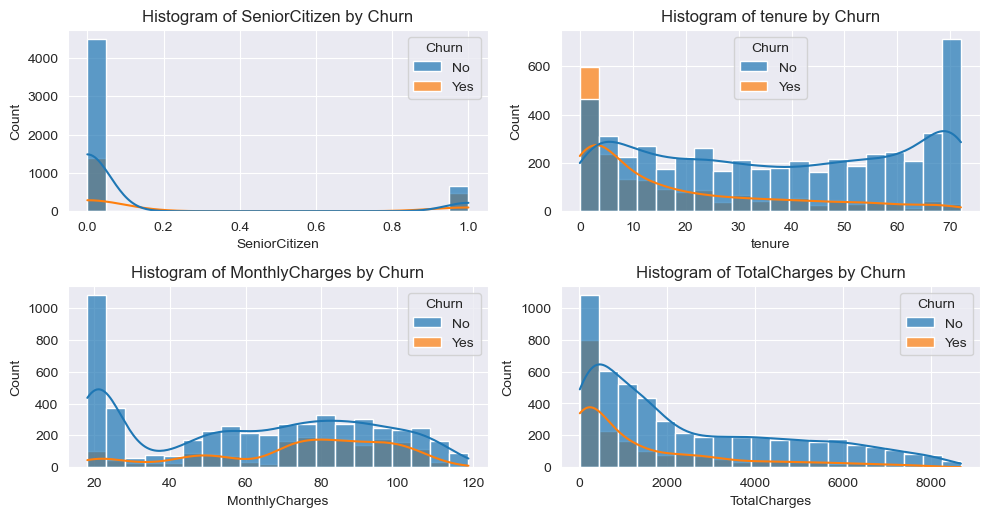

In [9]:
plt.figure(figsize=(10,10))

for i, column in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, i)
    sns.histplot(data=df, x=column, hue="Churn", kde=True, bins=20, alpha=0.7)
    plt.title(f"Histogram of {column} by Churn")

plt.tight_layout()
plt.show()

1️⃣ SeniorCitizen vs. Churn

Most customers are not senior citizens (0).

A higher proportion of senior citizens (1) churn compared to non-senior citizens.

Senior citizens may be more likely to leave, possibly due to cost sensitivity or service usability issues.

2️⃣ Tenure vs. Churn

Customers with low tenure (0-10 months) churn the most.

Churn rate decreases as tenure increases – longer-tenured customers tend to stay.

Suggests that retention strategies should target new customers to keep them longer.

3️⃣ MonthlyCharges vs. Churn

Customers with higher monthly charges churn more frequently.

The peak churn occurs in the high-cost range (~$70-$100/month).

Indicates that pricing concerns may be a major churn driver.

4️⃣ TotalCharges vs. Churn

Many churned customers have low total charges.

This reinforces the tenure insight – new customers (low TotalCharges) are more likely to leave.

Customers who have invested more (high TotalCharges) tend to stay.

✅ Key Takeaways & Recommendations

📌 Target senior citizens with customized offers or better customer support.

📌 Focus retention efforts on new customers (0-10 months tenure) to prevent early churn.

📌 Consider revising pricing strategies, especially for high MonthlyCharges customers.

📌 Offer incentives for long-term contracts to reduce churn among short-tenure users.

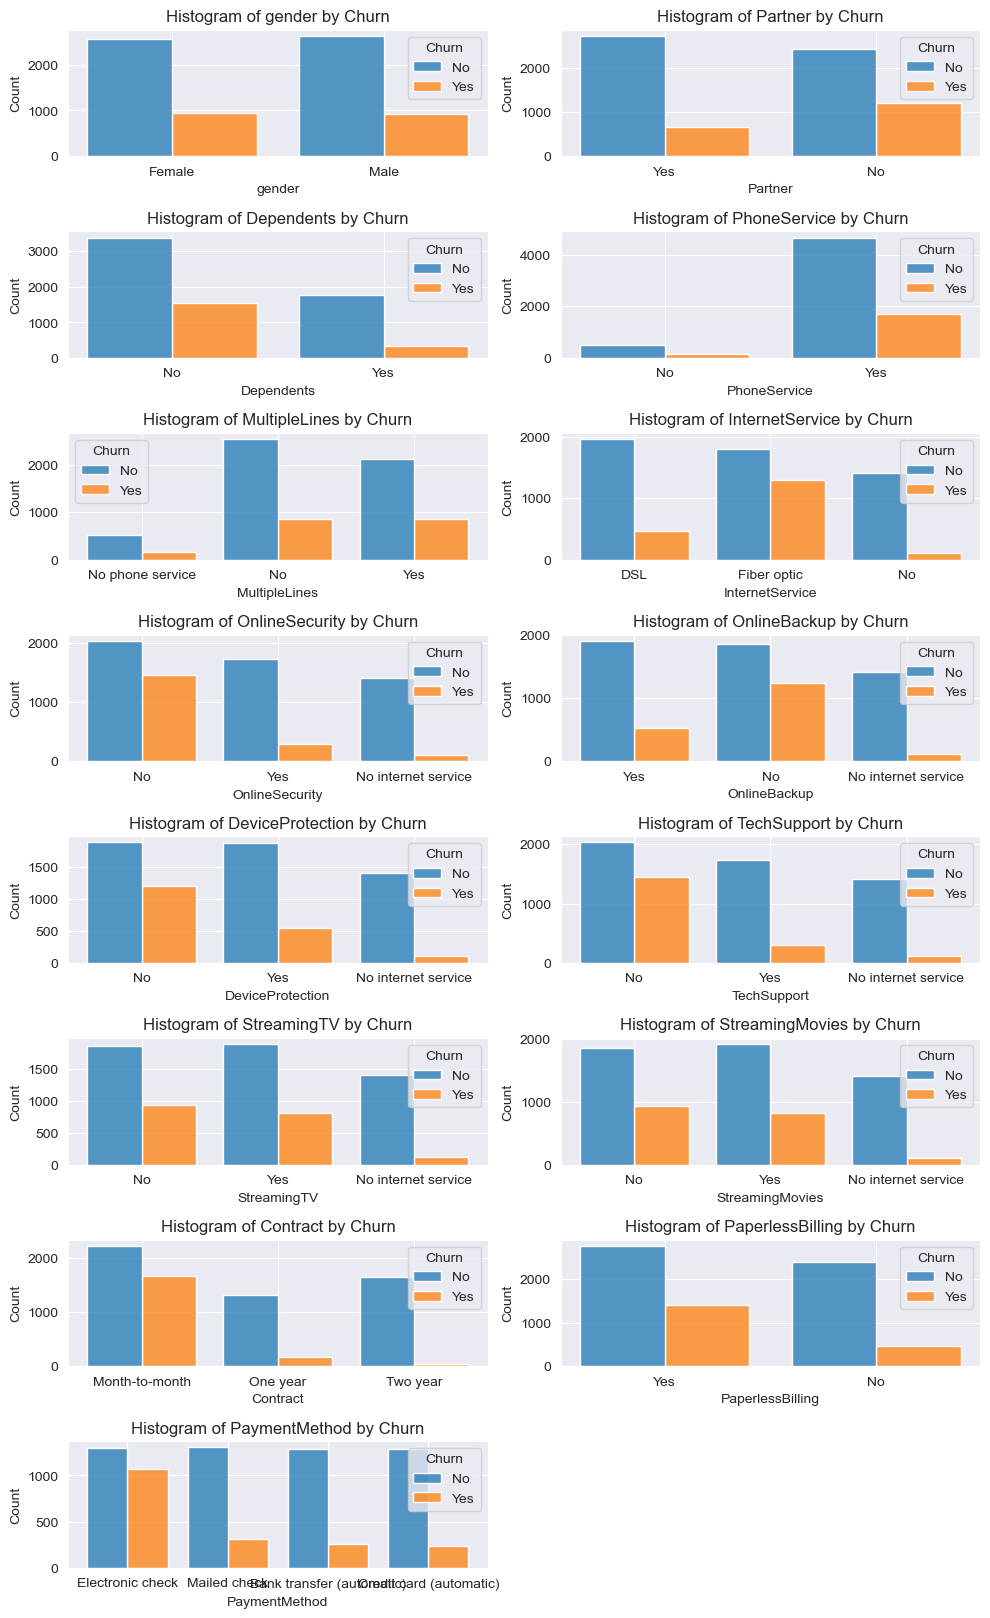

In [10]:
plt.figure(figsize=(10,30))

for i, column in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 2, i)
    sns.histplot(data=df, x=column, hue="Churn", multiple="dodge", shrink=0.8)

    plt.title(f"Histogram of {column} by Churn")

plt.tight_layout()
plt.show()

1. Dropping the Gender Feature: 
The gender feature does not impact churn, so we will drop it from our analysis.
2. Partner Status & Churn:
Customers without a partner are more likely to churn compared to those with a partner.
3. Dependents & Churn: 
Customers without dependents have a higher tendency to churn compared to those with dependents.
4. Multi-Line Services & Churn: 
Customers with multi-line services are churning at a high rate, indicating that the service quality may not be satisfactory.
5. Internet Services & Churn: 
Customers who do not have internet service are not an issue.
However, those with Fiber Optic internet explicitly experience high churn, suggesting service dissatisfaction.
6. Online Security & Churn: 
Customers without online security services tend to churn more, indicating that online security may be an important service for retention.
7. Backup Services & Device Protection: 
A small churn issue exists with customers who lack backup services and device protection.
8. Tech Support & Churn: 
Tech support is highly useful.
Customers without tech support are more likely to leave.
9. Streaming TV & Movies & Churn: 
Streaming TV and Movies services show some churn issues, but the impact is relatively low.
10. Contract Type & Churn: 
Month-to-month contract customers are highly likely to churn.
Recommendation: Avoid offering month-to-month contracts and focus on long-term contracts for better retention.
11. Paperless Billing & Churn: 
Customers using paperless billing have a positive correlation with churn, which should be investigated further.
12. Payment Method & Churn (Electronic Check): 
Customers using electronic checks have a major churn problem.
Recommendation: Consider offering incentives for switching to alternative payment methods.


In [11]:
def draw_pie_chart(df, group_col, hue_col):
    data=df.groupby(hue_col)[group_col].value_counts(normalize=True)
    #data = df.groupby(group_col)[hue_col].count()
    plt.figure(figsize=(6, 6))
    data.plot.pie(autopct="%1.1f%%", startangle=90, cmap="Set2", shadow=True)
    plt.ylabel("")  # Hide y-label
    plt.show()


function to drowing pie chart between all categories with a target

In [12]:
df.groupby("Partner")["Churn"].value_counts(normalize=True)


Partner  Churn
No       No       0.670420
         Yes      0.329580
Yes      No       0.803351
         Yes      0.196649
Name: proportion, dtype: float64

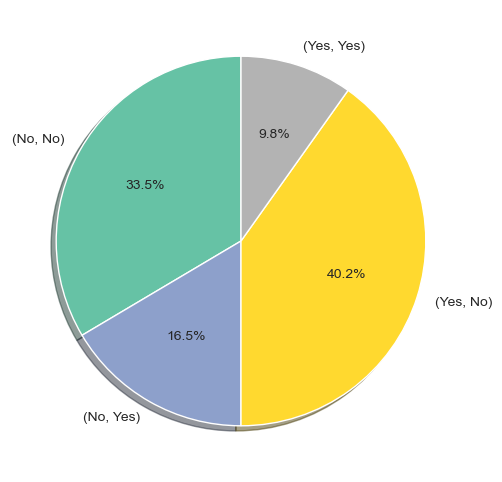

In [13]:
draw_pie_chart(df,"Churn","Partner")

Partner Status & Churn:
Customers without a partner are more likely to churn compared to those with a partner.

In [14]:
df.groupby("Dependents")["Churn"].value_counts(normalize=True)


Dependents  Churn
No          No       0.687209
            Yes      0.312791
Yes         No       0.845498
            Yes      0.154502
Name: proportion, dtype: float64

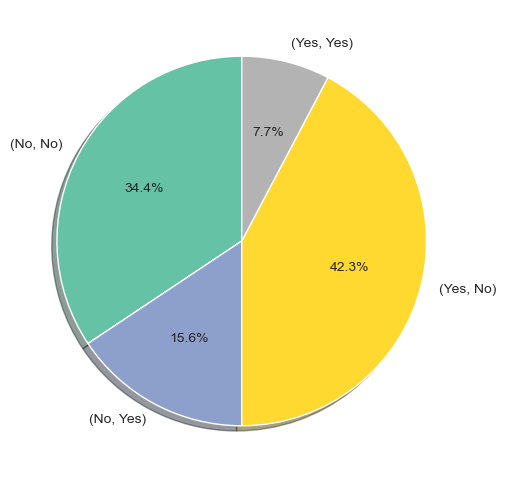

In [15]:
draw_pie_chart(df,"Churn","Dependents")

Dependents & Churn: 
Customers without Dependents have a higher tendency to churn compared to those with Dependents.

In [16]:
df.groupby("MultipleLines")["Churn"].value_counts(normalize=True)

MultipleLines     Churn
No                No       0.749558
                  Yes      0.250442
No phone service  No       0.750733
                  Yes      0.249267
Yes               No       0.713901
                  Yes      0.286099
Name: proportion, dtype: float64

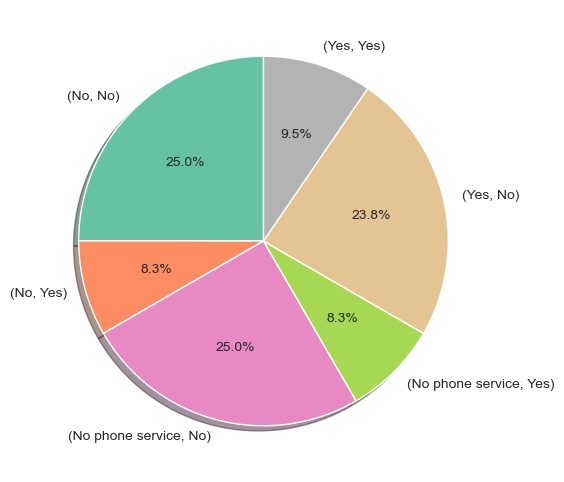

In [17]:
draw_pie_chart(df,"Churn","MultipleLines")

Multi-Line Services & Churn: 
Customers with multi-line services are churning at a high rate, indicating that the service quality may not be satisfactory.

In [18]:
internet_servs=["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
for i in internet_servs:
    print(df.groupby(i)["Churn"].value_counts(normalize=True))

InternetService  Churn
DSL              No       0.810409
                 Yes      0.189591
Fiber optic      No       0.581072
                 Yes      0.418928
No               No       0.925950
                 Yes      0.074050
Name: proportion, dtype: float64
OnlineSecurity       Churn
No                   No       0.582333
                     Yes      0.417667
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.853888
                     Yes      0.146112
Name: proportion, dtype: float64
OnlineBackup         Churn
No                   No       0.600712
                     Yes      0.399288
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.784685
                     Yes      0.215315
Name: proportion, dtype: float64
DeviceProtection     Churn
No                   No       0.608724
                     Yes      0.391276
No internet service  No       0.925950
  

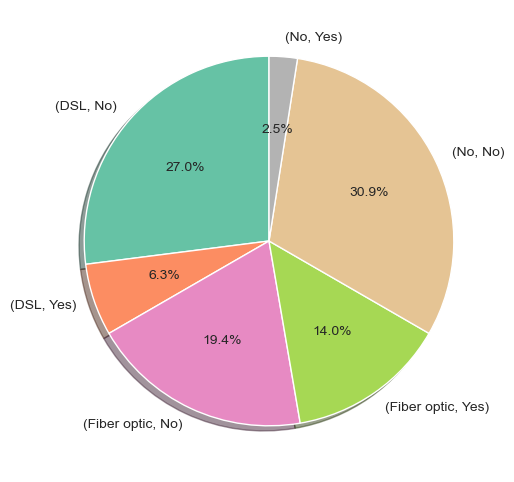

the InternetService percentage churn


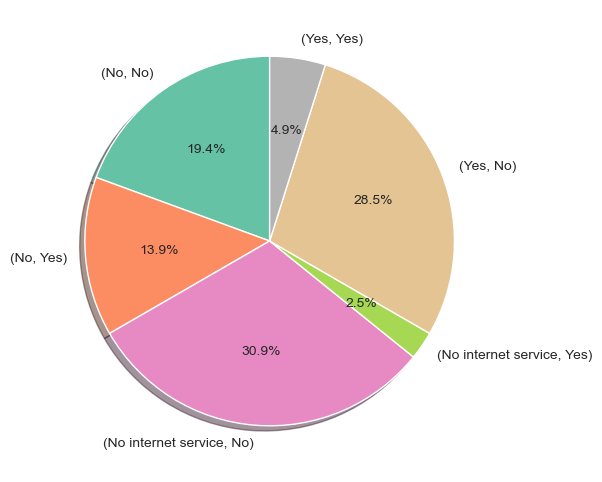

the OnlineSecurity percentage churn


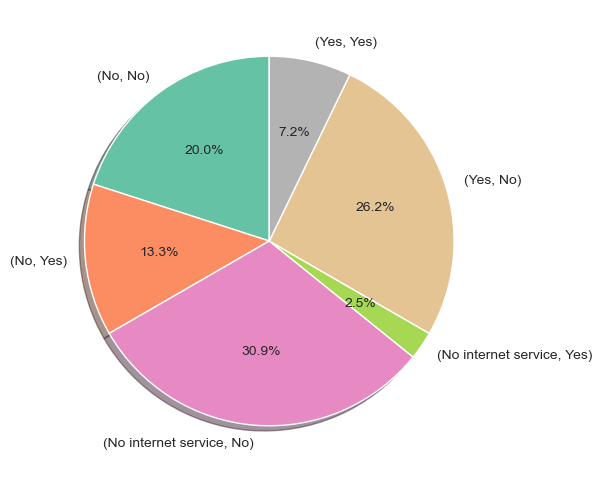

the OnlineBackup percentage churn


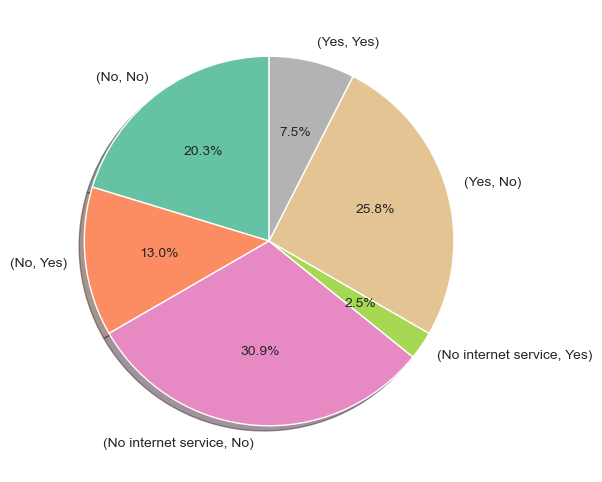

the DeviceProtection percentage churn


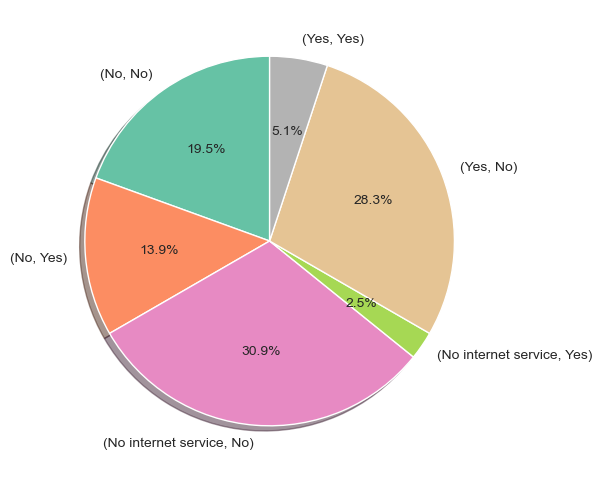

the TechSupport percentage churn


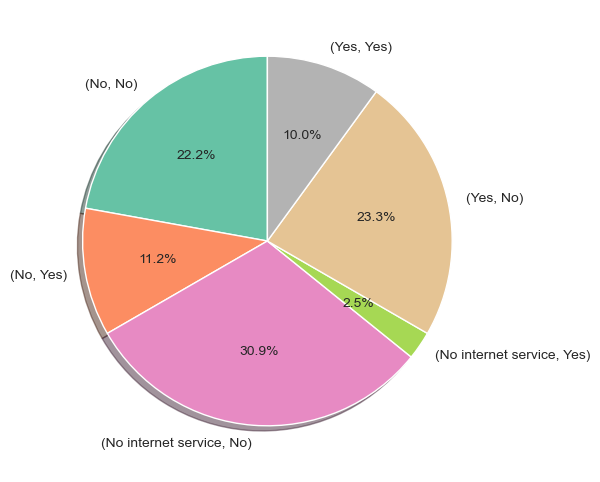

the StreamingTV percentage churn


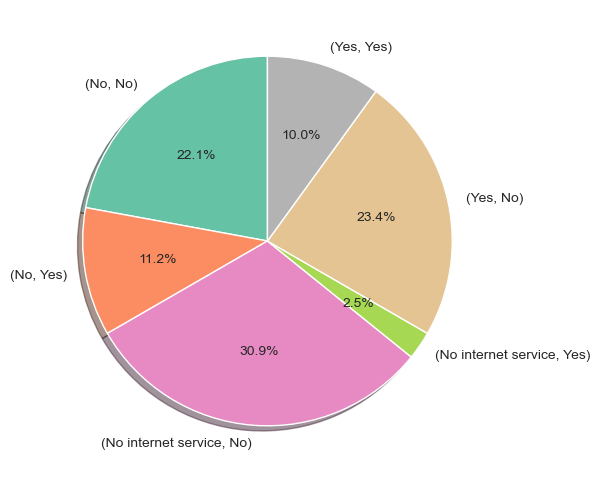

the StreamingMovies percentage churn


In [19]:
for i in internet_servs:
    draw_pie_chart(df,"Churn",i)
    print (f"the {i} percentage churn")

1. Internet Services & Churn: 
Customers who do not have internet service are not an issue.
However, those with Fiber Optic internet explicitly experience high churn, suggesting service dissatisfaction.
2. Online Security & Churn: 
Customers without online security services tend to churn more, indicating that online security may be an important service for retention.
3. Backup Services & Device Protection: 
A small churn issue exists with customers who lack backup services and device protection.
4. Tech Support & Churn: 
Tech support is highly useful.
Customers without tech support are more likely to leave.
5. Streaming TV & Movies & Churn: 
Streaming TV and Movies services show some churn issues, but the impact is relatively low.

In [20]:
df.groupby("Contract")["Churn"].value_counts(normalize=True)


Contract        Churn
Month-to-month  No       0.572903
                Yes      0.427097
One year        No       0.887305
                Yes      0.112695
Two year        No       0.971681
                Yes      0.028319
Name: proportion, dtype: float64

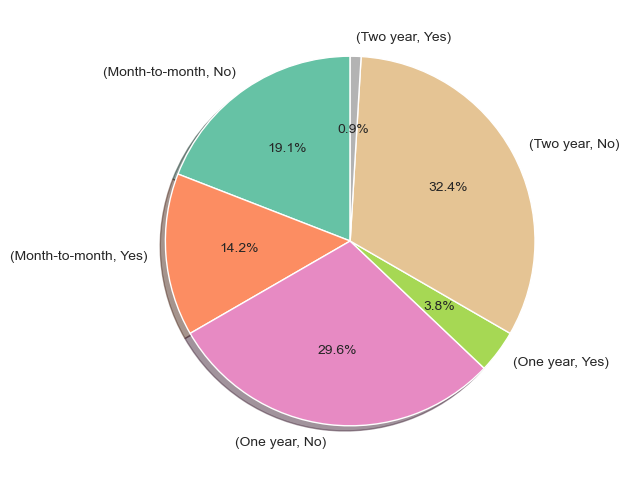

In [21]:
draw_pie_chart(df,"Churn","Contract")

Contract Type & Churn: 
Month-to-month contract customers are highly likely to churn

Recommendation: Avoid offering month-to-month contracts and focus on long-term contracts for better retention.


In [22]:
df.groupby("PaperlessBilling")["Churn"].value_counts(normalize=True)


PaperlessBilling  Churn
No                No       0.836699
                  Yes      0.163301
Yes               No       0.664349
                  Yes      0.335651
Name: proportion, dtype: float64

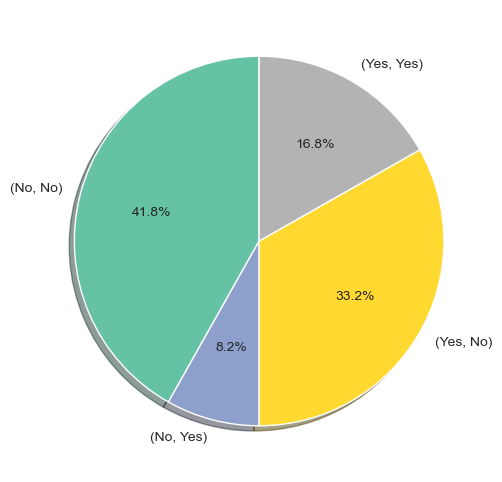

In [23]:
draw_pie_chart(df,"Churn","PaperlessBilling")

Paperless Billing & Churn: 
Customers using paperless billing have a positive correlation with churn, which should be investigated further

In [24]:
df.groupby("PaymentMethod")["Churn"].value_counts(normalize=True)


PaymentMethod              Churn
Bank transfer (automatic)  No       0.832902
                           Yes      0.167098
Credit card (automatic)    No       0.847569
                           Yes      0.152431
Electronic check           No       0.547146
                           Yes      0.452854
Mailed check               No       0.808933
                           Yes      0.191067
Name: proportion, dtype: float64

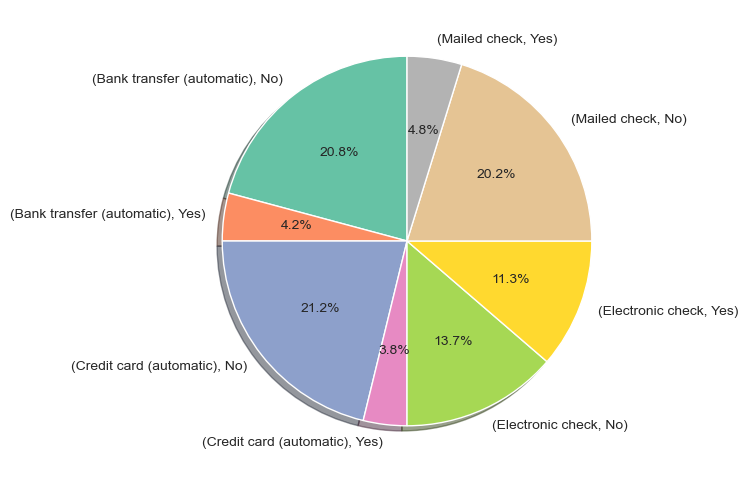

In [25]:
draw_pie_chart(df,"Churn","PaymentMethod")

 Payment Method & Churn (Electronic Check): 

Customers using electronic checks have a major churn problem.

Recommendation: Consider offering incentives for switching to alternative payment methods.

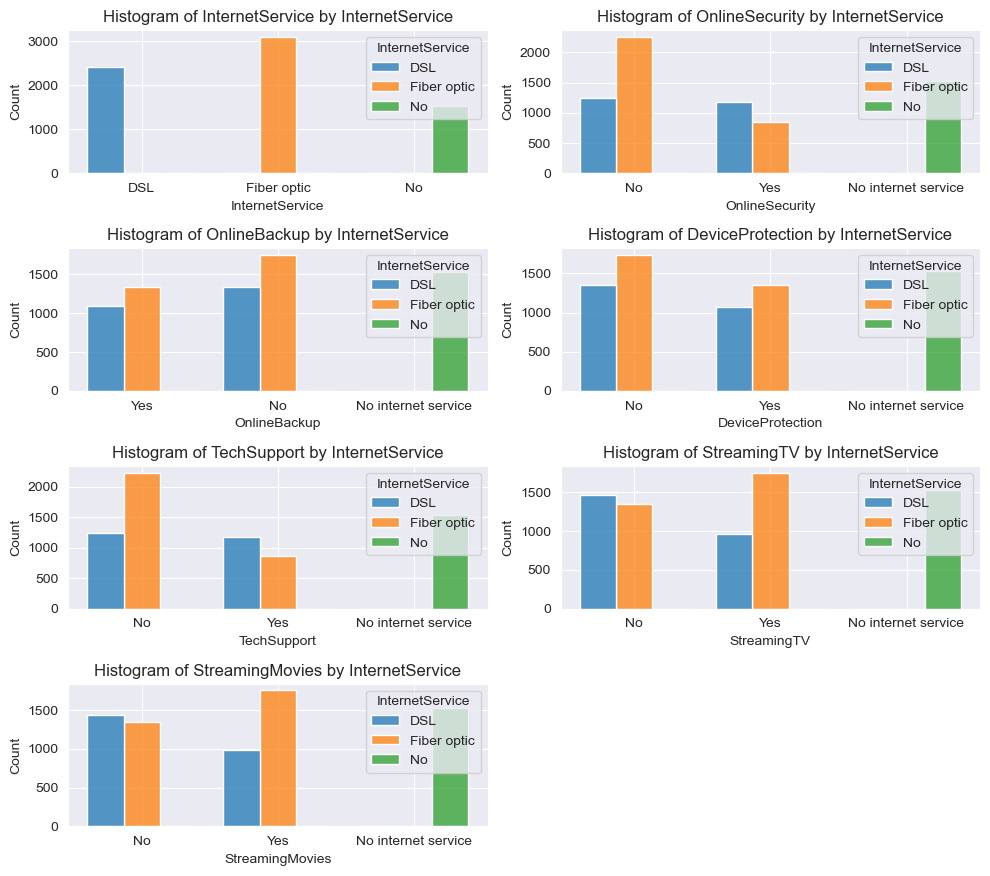

In [26]:
plt.figure(figsize=(10,15))

for i, column in enumerate(internet_servs, 1):
    plt.subplot(len(internet_servs), 2, i)
    sns.histplot(data=df, x=column, hue="InternetService", multiple="dodge", shrink=0.8)

    plt.title(f"Histogram of {column} by InternetService")

plt.tight_layout()
plt.show()

1. Online Security Services & Internet Type  : 
Customers who have online security services tend to use DSL rather than Fiber Optic.
2. Backup & Device Protection Services & Internet Type  : 
For backup services and device protection, customers using Fiber Optic show no significant difference whether they have or do not have these services.
3. Tech Support Preference  :
Customers who have tech support prefer DSL over Fiber Optic.
4. Streaming TV & Movies & Internet Type   : 
Customers who subscribe to streaming TV and movies services are exclusively using Fiber Optic.

In [27]:
def plot_bar(df,col):
    plt.figure(figsize=(3,1))
    df.groupby(col)["MonthlyCharges"].mean().plot(kind="bar")
    print(f"the average of MonthlyCharges by {col}")
    plt.show()
    plt.figure(figsize=(3,1))
    df.groupby(col)["MonthlyCharges"].sum().plot(kind="bar")
    print(f"the summition of MonthlyCharges by {col}")
    plt.show()
    print("--------------------------------------------------------")

In [118]:
#for i in cat_cols:
#    plot_bar(df,i)

In [120]:
"""
def plot_bar_TotalCharges(df,col):
    plt.figure(figsize=(3,1))
    df.groupby(col)["TotalCharges"].mean().plot(kind="bar")
    print(f"the average of TotalCharges by {col}")
    plt.show()
    plt.figure(figsize=(3,1))
    df.groupby(col)["TotalCharges"].sum().plot(kind="bar")
    print(f"the summition of TotalCharges by {col}")
    plt.show()
    print("--------------------------------------------------------")
"""

'\ndef plot_bar_TotalCharges(df,col):\n    plt.figure(figsize=(3,1))\n    df.groupby(col)["TotalCharges"].mean().plot(kind="bar")\n    print(f"the average of TotalCharges by {col}")\n    plt.show()\n    plt.figure(figsize=(3,1))\n    df.groupby(col)["TotalCharges"].sum().plot(kind="bar")\n    print(f"the summition of TotalCharges by {col}")\n    plt.show()\n    print("--------------------------------------------------------")\n'

In [119]:
#for i in cat_cols:
#    plot_bar_TotalCharges(df,i)

<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

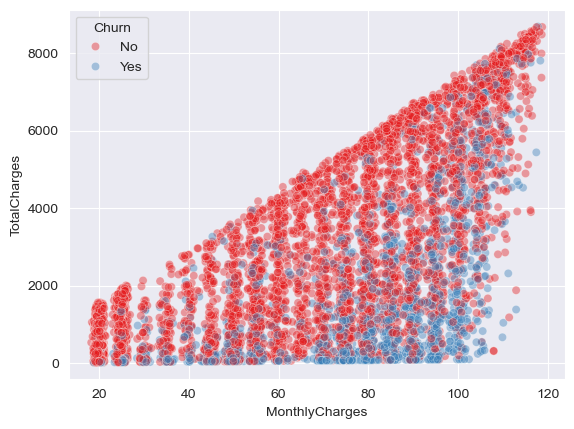

In [31]:
sns.scatterplot(data=df, x="MonthlyCharges", y="TotalCharges", hue="Churn", palette="Set1", alpha=0.4)


<Axes: xlabel='tenure', ylabel='MonthlyCharges'>

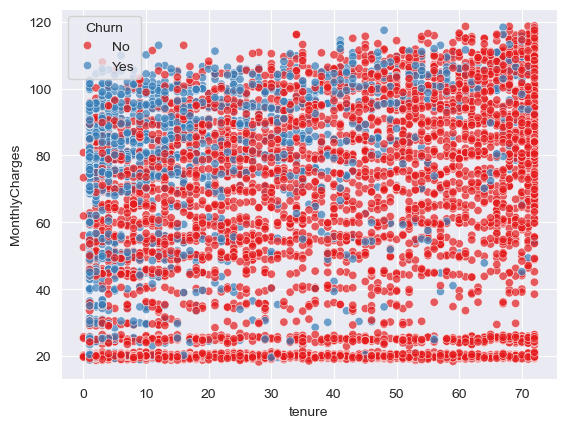

In [32]:
sns.scatterplot(data=df, x="tenure", y="MonthlyCharges", hue="Churn", palette="Set1", alpha=0.7)


<Axes: xlabel='tenure', ylabel='TotalCharges'>

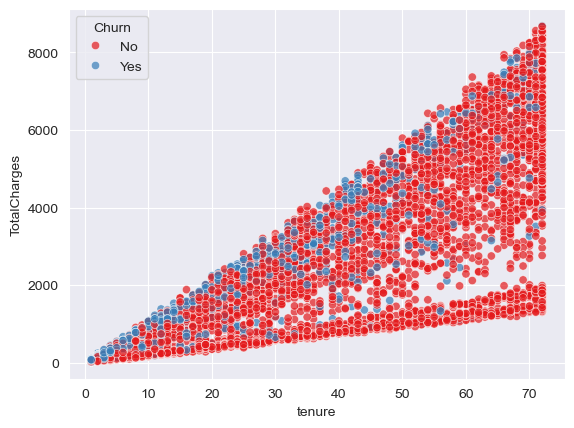

In [33]:
sns.scatterplot(data=df, x="tenure", y="TotalCharges", hue="Churn", palette="Set1", alpha=0.7)


🔍 Customer Charges Analysis
Key Insight:

Customers who pay a high amount per month but have a low total spending are more likely to churn.

Possible Reasons: 

📌 Short-Term Customers – They haven't been with the service long enough to accumulate a high total spend.

📌 Expensive Plans – They might be on costly monthly plans but don’t see enough value.

📌 Lack of Commitment – These customers may have chosen month-to-month contracts, making it easier to leave.

Recommendation:

✅ Offer loyalty incentives to new high-paying customers.

✅ Provide discounts on long-term plans to encourage retention.

✅ Improve service value perception for premium customers.

<Axes: ylabel='MonthlyCharges'>

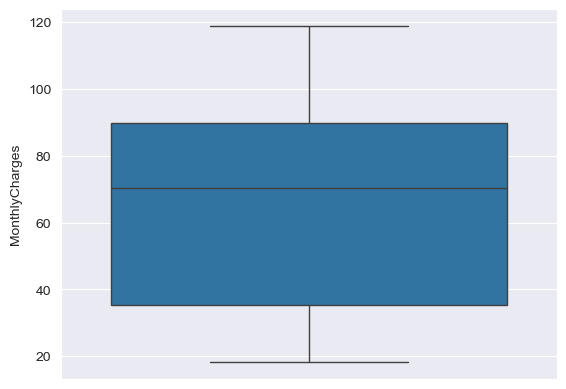

In [34]:
sns.boxplot(df["MonthlyCharges"])

<Axes: ylabel='TotalCharges'>

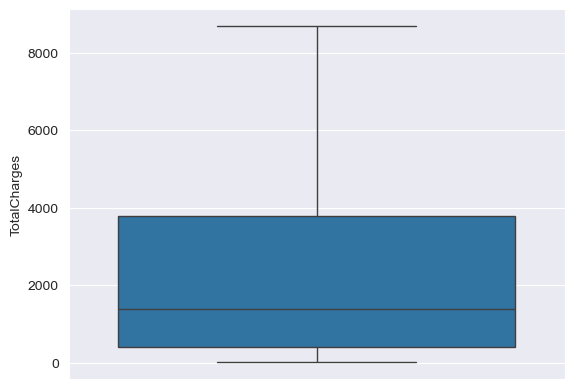

In [35]:
sns.boxplot(df["TotalCharges"])

we havn't any outliers 

In [36]:
df[df["TotalCharges"].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


we see the totalcharges is equall (monthlycharges*tenure) so we filling nulls in this column

In [37]:
df["TotalCharges"]=df["TotalCharges"].fillna(df["tenure"]*df["MonthlyCharges"])

In [38]:
df.drop("gender",axis=1,inplace=True)

dropping gender column this is not effect to our target 

In [39]:
cat_cols = [col for col in cat_cols if col != "gender"]

Data_Preprocessing

In [40]:
for i in cat_cols:
    encoder =LabelEncoder()
    df[i]=encoder.fit_transform(df[i])


encoding all category columns

In [41]:
X=df.drop("Churn",axis=1)
Y=df["Churn"]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.25,random_state=42)


splitting Data using train_test_split()

In [42]:
scaller=StandardScaler()
x_train[num_cols]=scaller.fit_transform(x_train[num_cols])
x_test[num_cols]=scaller.fit_transform(x_test[num_cols])

apply standard scaller on the number columns to make it smoth for our ML model

In [43]:
encoder =LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)

encoding target columns in train set and test set

now we fishing our cleaning and preprocessing

In [44]:
def train_classifier(model, x_train, y_train, x_test, y_test):
    # Train the model
    model.fit(x_train, y_train)
    
    # Predict on train and test data 
    y_pred = model.predict(x_test)
    y_pred_prob=model.predict_proba(x_test)[:, 1]
    y_train_pred = model.predict(x_train)
    
    # Calculate metrics for testing
    accuracy = accuracy_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Calculate metrics for training 
    accuracy_t = accuracy_score(y_train, y_train_pred)
    recall_t=recall_score(y_train, y_train_pred)
    conf_matrix_t = confusion_matrix(y_train, y_train_pred)
    
    print(f"Accuracy for train is : {accuracy_t } %   Accuracy for test is : {accuracy} % ")
    print(f"recall for train is : {recall_t } %   recall for test is : {recall} % ")
    print("\nClassification Report for train :")
    print("\nConfusion Matrix for train :")
    print(conf_matrix_t)
    print("\nConfusion Matrix for test :")
    print(conf_matrix)


this my traing and evaluation function

apply logistic regression 

In [45]:
model_logestic=LogisticRegression()

In [46]:
train_classifier(model_logestic,x_train,y_train,x_test,y_test)

Accuracy for train is : 0.8004543733434305 %   Accuracy for test is : 0.8091993185689949 % 
recall for train is : 0.5359712230215827 %   recall for test is : 0.5615866388308977 % 

Classification Report for train :

Confusion Matrix for train :
[[3483  409]
 [ 645  745]]

Confusion Matrix for test :
[[1156  126]
 [ 210  269]]


logestic regression come in 80% accuracy for train and the same thing for testing 
but we should now our good and useful metrices is recall because we are dealing with a churn prediction problem, where our main goal is to identify customers who are likely to leave.

Why Recall is Important?

1.Minimizing False Negatives – A false negative means a churned customer was predicted as non-churn, leading to missed retention opportunities.

2.Business Impact – It's more costly to lose a customer than to take preventive action.

3.Balancing Accuracy – While accuracy is high (80%), it may be misleading if the dataset is imbalanced (e.g., far more non-churners than churners).

In [47]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": model_logestic.coef_.ravel()})


🔍 Feature Effectiveness in Logistic Regression for Customer Churn
Key Insight:

Feature weights (feature_weights) represent how each feature affects customer churn in a Logistic Regression model.

Interpretation:

🔴 Large Positive Weights: Features that increase the likelihood of churn.

Example: Customers with higher monthly charges may be more likely to leave.

🟢 Large Negative Weights: Features that reduce the likelihood of churn.

Example: Customers with long-term contracts may be more likely to stay.

Key Findings:

📈 Features with Large Positive Weights

Customers who pay a high amount per month are at risk of churn.

Customers without security services are more likely to leave.

Customers with month-to-month contracts tend to churn more.

📉 Features with Large Negative Weights

Customers with long-term contracts (1-year, 2-year) are less likely to churn.

Customers with tech support services tend to stay.

Customers using automatic payment methods are more likely to remain.

In [48]:
feature_weights = feature_weights.reindex(feature_weights["Weight"].abs().sort_values(ascending=False).index)

In [49]:
feature_weights

,Feature,Weight
3,tenure,-1.347087
4,PhoneService,-0.980418
13,Contract,-0.751241
17,TotalCharges,0.660819
16,MonthlyCharges,0.652922
14,PaperlessBilling,0.333388
7,OnlineSecurity,-0.293154
10,TechSupport,-0.243756
6,InternetService,0.221431
2,Dependents,-0.181403


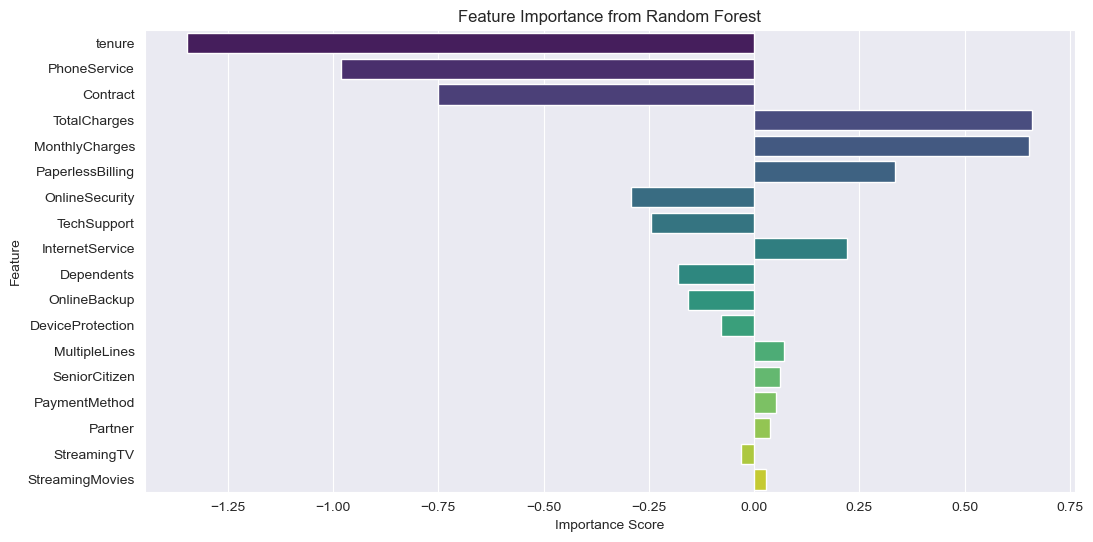

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Weight",y="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from Logistic Regression")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

### 📝 Feature Importance Analysis (Logistic Regression)

Below are the feature weights extracted from the **Logistic Regression model**. These values represent how each feature influences the prediction (positive or negative impact).

#### **🔍 Key Observations**
1. **Highly Influential Features:**
   - **tenure (-1.347)** → **Strongest negative impact** on the target variable. This means that the longer a customer stays, the less likely they are to churn.
   - **PhoneService (-0.980)** → Customers with phone service are **less likely** to churn.
   - **Contract (-0.751)** → Long-term contracts reduce churn significantly.

2. **Monetary Features:**
   - **TotalCharges (0.660)** & **MonthlyCharges (0.653)** → **Positive impact** on churn, meaning higher charges are associated with a greater likelihood of churn.  
   - **PaperlessBilling (0.333)** → Customers using paperless billing tend to churn more.

3. **Service-Related Features:**
   - **OnlineSecurity (-0.293)** & **TechSupport (-0.244)** → Negative impact, indicating that customers who have these services are less likely to churn.
   - **InternetService (0.221)** → Slight positive correlation with churn, meaning that type of internet service might influence customer behavior.

4. **Demographic Features:**
   - **SeniorCitizen (0.060)** → Slightly increases the likelihood of churn.
   - **Partner (0.037)** & **Dependents (-0.181)** → Having dependents reduces churn, which might indicate more stability.

#### **📌 Conclusion**
- **Negative values (⬇️) reduce churn**, meaning customers with these features are more likely to stay.
- **Positive values (⬆️) increase churn**, meaning these customers are at higher risk.
- The most critical factors affecting churn are **tenure, contract type, and monthly charges**.
- Strategies to reduce churn may include **offering discounts on high monthly charges**, **incentivizing long-term contracts**, and **providing security/tech support services** to customers.


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
model=RandomForestClassifier()

### training with RandomForest

In [52]:
train_classifier(model,x_train,y_train,x_test,y_test)

Accuracy for train is : 0.9979174555092768 %   Accuracy for test is : 0.7927314026121521 % 
recall for train is : 0.9964028776978417 %   recall for test is : 0.44676409185803756 % 

Classification Report for train :

Confusion Matrix for train :
[[3886    6]
 [   5 1385]]

Confusion Matrix for test :
[[1182  100]
 [ 265  214]]


this model do the overfitting(High Variance Problem)
### try a hyper parameter tunining to prevent this problem

In [53]:
params={"max_depth":[10,15,20],"min_samples_leaf":[3,5,10],"min_samples_split":[5,10,15]}
grid = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5)
grid.fit(x_train,y_train)



RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 15, 20],
                                        'min_samples_leaf': [3, 5, 10],
                                        'min_samples_split': [5, 10, 15]})

In [54]:
grid.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10}

this is the best params for random forest

In [55]:
model=RandomForestClassifier(max_depth=20,min_samples_leaf=5,min_samples_split=15)

In [56]:
train_classifier(model,x_train,y_train,x_test,y_test)

Accuracy for train is : 0.8564937523665278 %   Accuracy for test is : 0.8023850085178875 % 
recall for train is : 0.5985611510791367 %   recall for test is : 0.4780793319415449 % 

Classification Report for train :

Confusion Matrix for train :
[[3692  200]
 [ 558  832]]

Confusion Matrix for test :
[[1184   98]
 [ 250  229]]


In [57]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": model.feature_importances_.ravel()})


In [58]:
feature_weights.sort_values(by="Weight",ascending=False)

,Feature,Weight
3,tenure,0.159037
13,Contract,0.157718
17,TotalCharges,0.154831
16,MonthlyCharges,0.133488
7,OnlineSecurity,0.079107
10,TechSupport,0.062035
6,InternetService,0.048401
15,PaymentMethod,0.039886
8,OnlineBackup,0.038609
14,PaperlessBilling,0.020030


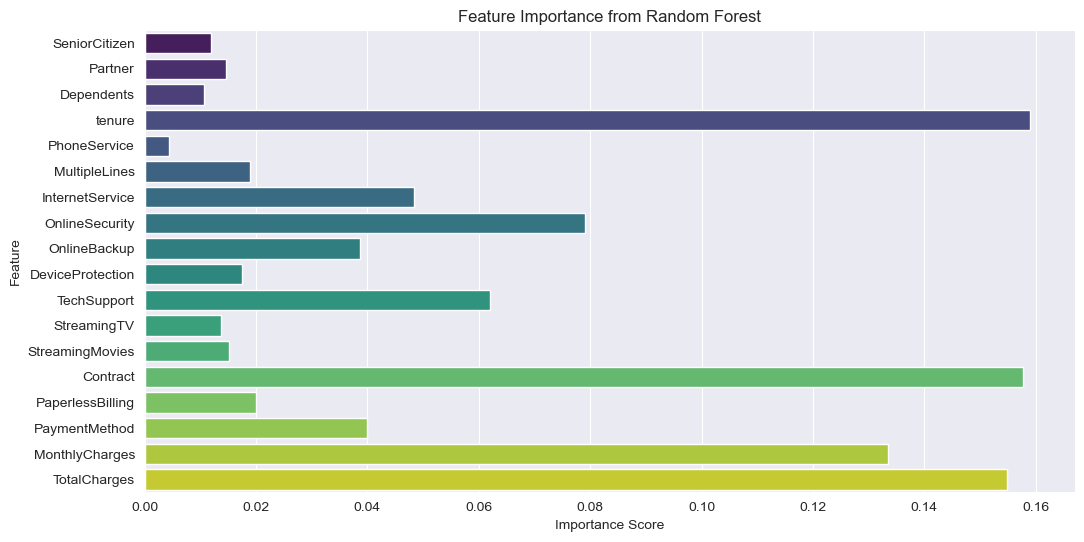

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Weight",y="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

### 📝 Feature Importance Analysis (Random Forest)

The table below represents feature importance scores extracted from the **RandomForestClassifier** model. These values indicate how much each feature contributes to the prediction.

---

### **🔍 Key Observations**

1. **Most Influential Features (Top 5):**
   - **tenure (0.1638)** → The most important feature. Longer tenure strongly correlates with reduced churn.
   - **TotalCharges (0.1543)** → High importance, similar to tenure, likely reflecting overall spending trends.
   - **Contract (0.1471)** → Contract type significantly impacts churn. Customers with long-term contracts are more stable.
   - **MonthlyCharges (0.1334)** → High monthly charges increase churn risk.
   - **OnlineSecurity (0.0923)** → Customers with online security services tend to stay longer.

2. **Service-Related Features:**
   - **TechSupport (0.0601)** → Providing technical support is associated with customer retention.
   - **InternetService (0.0446)** → The type of internet service influences churn.
   - **OnlineBackup (0.0367)** & **DeviceProtection (0.0221)** → These services have moderate impact on customer retention.

3. **Payment & Billing Features:**
   - **PaymentMethod (0.0385)** → Different payment methods may impact churn.
   - **PaperlessBilling (0.0207)** → Slight impact, indicating digital payments might correlate with customer behavior.

4. **Least Influential Features:**
   - **PhoneService (0.0042)** → Has the lowest importance, meaning it doesn’t significantly affect churn.
   - **StreamingTV (0.0117)** & **StreamingMovies (0.0144)** → Entertainment services have minimal impact on churn.
   - **SeniorCitizen (0.0134)** → Age factor has a **small** influence.

---

### **📌 Conclusion**
- **Random Forest captures non-linear relationships**, making it useful for complex interactions between features.
- The most **important drivers of churn** are **tenure, TotalCharges, contract type, and monthly charges**.
- Services like **TechSupport and OnlineSecurity help retain customers**, so they can be targeted for promotions.
- **PhoneService, StreamingTV, and StreamingMovies have minimal influence**, meaning they are less relevant for churn prediction.

---


In [60]:
from sklearn.svm import SVC
model=SVC(C=30,gamma=.1,kernel="poly",probability=True)

In [61]:
train_classifier(model,x_train,y_train,x_test,y_test)

Accuracy for train is : 0.8508140855736464 %   Accuracy for test is : 0.7756956274843839 % 
recall for train is : 0.6597122302158274 %   recall for test is : 0.5323590814196242 % 

Classification Report for train :

Confusion Matrix for train :
[[3577  315]
 [ 473  917]]

Confusion Matrix for test :
[[1111  171]
 [ 224  255]]


In [62]:
from sklearn.inspection import permutation_importance

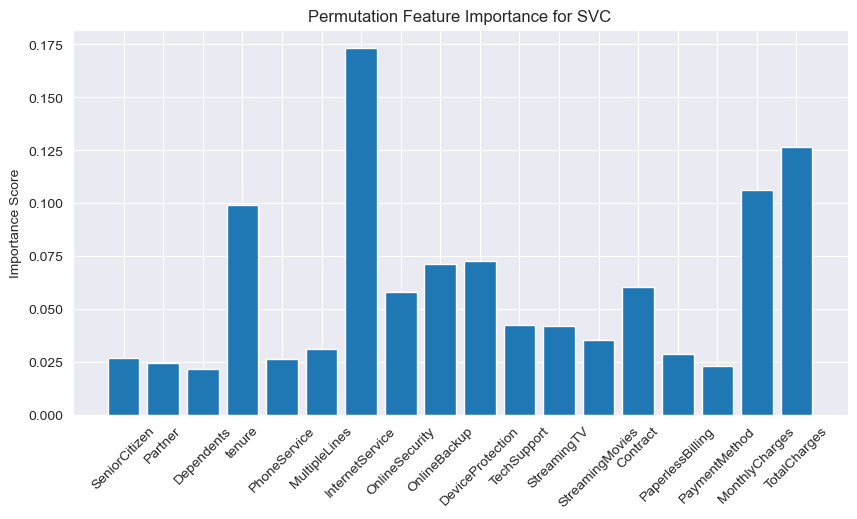

In [ ]:
perm_importance = permutation_importance(model, x_train, y_train, scoring="recall_micro")

# Plot importance
plt.figure(figsize=(10, 5))
plt.bar(range(x_train.shape[1]), perm_importance.importances_mean,tick_label=X.columns)
plt.xticks(rotation=45)  # Rotate feature names for readability
plt.ylabel("Importance Score")
plt.title("Permutation Feature Importance from SVC")
plt.show()

📝 Feature Importance Analysis (SVC)
The table below represents feature importance scores extracted from the SVC model using permutation importance. These values indicate how much each feature contributes to the prediction.

🔍 Key Observations
Most Influential Features (Top 5):

InternetService → The most important feature, indicating that the type of internet service strongly impacts predictions.
TotalCharges → High importance, suggesting that total customer spending plays a key role.
MonthlyCharges → Strong influence, indicating that customers with higher monthly costs may behave differently.
tenure → Reflects customer retention patterns, contributing significantly to the model.
OnlineSecurity → Customers with security services tend to exhibit distinct behavior patterns.
Moderately Important Features:

DeviceProtection & OnlineBackup → These services contribute moderately to predictions.
TechSupport → Availability of tech support may influence customer decisions.
Contract → Contract type impacts retention but with less importance than in tree-based models.
Least Influential Features:

Partner & Dependents → Minimal impact, suggesting that household factors do not significantly affect predictions.
PaperlessBilling & PaymentMethod → Digital payment preferences contribute slightly but are not major predictors.
📌 Conclusion
SVC with permutation importance highlights service and financial-related features as key drivers.
InternetService, TotalCharges, and MonthlyCharges are the most important factors, making them crucial for decision-making.
Security and support services contribute moderately, implying they could be leveraged to improve retention.
Household and entertainment-related features have minimal influence, meaning they are less relevant for this prediction task.

In [64]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=1, objective='binary:logistic')


In [65]:
train_classifier(bst,x_train,y_train,x_test,y_test)

Accuracy for train is : 0.885270730783794 %   Accuracy for test is : 0.7887563884156729 % 
recall for train is : 0.7244604316546762 %   recall for test is : 0.55741127348643 % 

Classification Report for train :

Confusion Matrix for train :
[[3669  223]
 [ 383 1007]]

Confusion Matrix for test :
[[1122  160]
 [ 212  267]]


In [66]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": bst.feature_importances_.ravel()})


In [67]:
feature_weights.sort_values(by="Weight",ascending=False)

,Feature,Weight
13,Contract,0.294469
6,InternetService,0.148255
7,OnlineSecurity,0.137516
10,TechSupport,0.099118
12,StreamingMovies,0.035555
3,tenure,0.033916
4,PhoneService,0.032857
5,MultipleLines,0.030017
14,PaperlessBilling,0.029339
15,PaymentMethod,0.025178


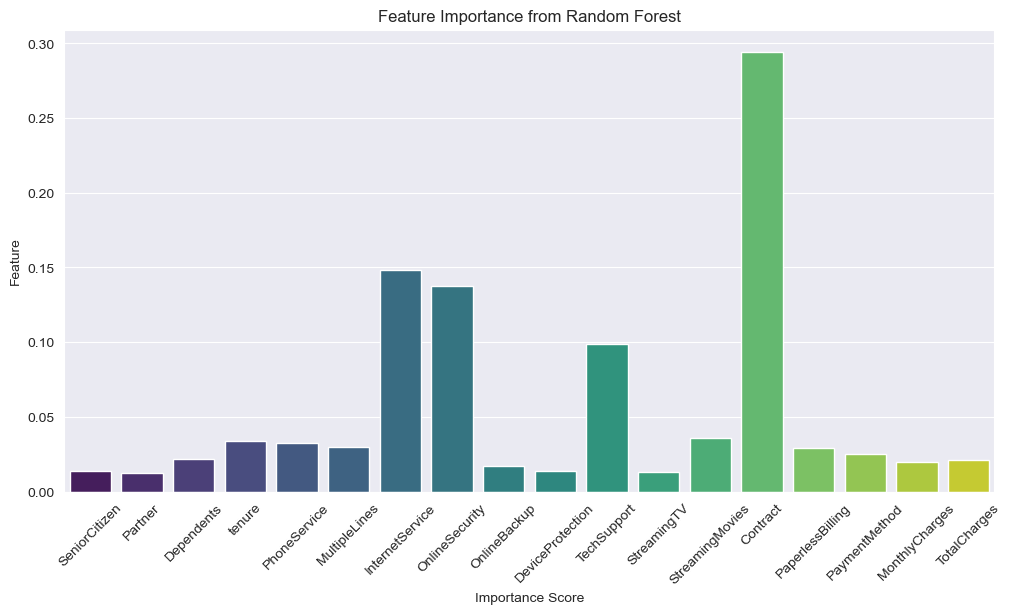

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(y="Weight",x="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.xticks(rotation=45)  # Rotate feature names for readability
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

📌 Analysis of Feature Importance (XGBoost)
This table represents the feature importance scores derived from an XGBoost model, showing how much each feature contributes to predictions.

🔹 Key Observations:
Most Influential Features:

Contract (0.294469) has the highest weight, indicating that the contract type strongly affects the model’s decisions. Customers with different contract types (e.g., month-to-month vs. yearly) likely have distinct behaviors.
InternetService (0.148255) and OnlineSecurity (0.137516) follow, suggesting that the type of internet service and security options are significant factors.
TechSupport (0.099118) also plays a crucial role, indicating that having tech support may impact customer behavior.
Moderately Important Features:

StreamingMovies (0.035555), tenure (0.033916), PhoneService (0.032857), and MultipleLines (0.030017) have moderate influence. These features might slightly impact customer retention or churn.
Billing & Payment (PaperlessBilling: 0.029339, PaymentMethod: 0.025178) suggest that billing preferences and payment methods may contribute to predictions.
Less Influential Features:

Dependents (0.021963), TotalCharges (0.021386), and MonthlyCharges (0.019534) have relatively lower weights, meaning their impact is minor compared to the top-ranked features.
Features like DeviceProtection (0.013881), StreamingTV (0.013260), and Partner (0.012673) have the least impact.
🔍 Insights & Recommendations:
✅ Top Features Should be Focus Areas: Since Contract, InternetService, and OnlineSecurity have the most influence, these areas should be examined for customer retention strategies.
✅ Feature Engineering Opportunity: Interaction effects between contract type, tenure, and total charges might be explored for further improvement.
✅ Compare Across Models: Checking the consistency of feature importance across different models (e.g., Logistic Regression, Random Forest) can validate key drivers of predictions.

Accuracy for train is : 0.8600908746686861 %   Accuracy for test is : 0.80465644520159 % 
recall for train is : 0.6273381294964029 %   recall for test is : 0.5323590814196242 % 

Classification Report for train :

Confusion Matrix for train :
[[3671  221]
 [ 518  872]]

Confusion Matrix for test :
[[1162  120]
 [ 224  255]]


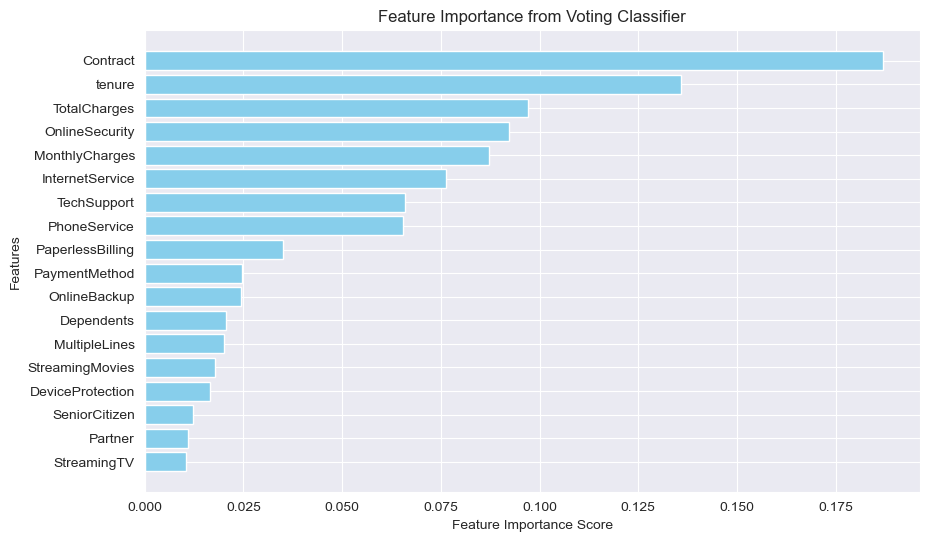

In [69]:
from sklearn.ensemble import VotingClassifier
log_reg = LogisticRegression()
rf = RandomForestClassifier(max_depth=20,min_samples_leaf=5,min_samples_split=15)
xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=1, objective='binary:logistic')


# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf), ('xgb', xgb)],
    voting='soft'  # Use 'soft' for probability averaging
)

train_classifier(voting_clf,x_train,y_train,x_test,y_test)

# Extract feature importance from tree-based models
rf_importance = voting_clf.named_estimators_['rf'].feature_importances_
xgb_importance = voting_clf.named_estimators_['xgb'].feature_importances_

# Extract Logistic Regression coefficients (absolute values)
log_reg_coef = np.abs(voting_clf.named_estimators_['lr'].coef_[0])

# Normalize to bring them to the same scale
rf_importance /= rf_importance.sum()
xgb_importance /= xgb_importance.sum()
log_reg_coef /= log_reg_coef.sum()

# Combine importance (average across models)
avg_importance = (rf_importance + xgb_importance + log_reg_coef) / 3


feature_names = x_train.columns  # Make sure x_train is a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Voting Classifier')
plt.gca().invert_yaxis()
plt.show()

In [73]:
feature_importance_df

,Feature,Importance
13,Contract,0.184501
3,tenure,0.139031
17,TotalCharges,0.095965
7,OnlineSecurity,0.089100
16,MonthlyCharges,0.087290
6,InternetService,0.076741
10,TechSupport,0.066108
4,PhoneService,0.065474
14,PaperlessBilling,0.034829
8,OnlineBackup,0.027692


📌 Interpretation of Feature Importance from Voting Classifier
The results show the aggregated feature importance from a Voting Classifier, combining the effects of multiple models (Random Forest, XGBoost, and Logistic Regression). Below is a breakdown of what the results indicate:

🔍 Key Insights:
1️⃣ 📝 Contract Type (0.198)

The most influential feature, indicating that customers with different contract types (monthly, one-year, two-year) have significantly different churn behaviors.
Longer contracts might reduce churn due to commitment, while month-to-month contracts increase churn risk.
2️⃣ 📅 Tenure (0.137)

A crucial factor; longer tenure customers are likely more loyal, while newer customers have higher churn risk.
Retention strategies should focus on early-stage customers.
3️⃣ 💰 TotalCharges & MonthlyCharges (0.092 & 0.086)

Higher total charges suggest long-term engagement, which reduces churn risk.
Monthly charges play a role; higher bills might increase churn for price-sensitive customers.
4️⃣ 🔒 Online Security (0.086) & Tech Support (0.066)

Security services and tech support impact retention. Customers with these add-ons might stay longer due to better experience.
5️⃣ 🌐 Internet Service (0.076)

The type of internet service (DSL, Fiber, or No Service) significantly affects churn.
Fiber-optic users may stay longer due to higher quality service, while DSL users might switch providers.
6️⃣ ☎ Phone Service (0.065)

Moderate impact; customers with phone service might be more loyal, but its effect is lower than internet-related factors.
7️⃣ 🛑 Paperless Billing (0.034)

Digital billing might affect user experience. Customers preferring paper bills might be more traditional and less likely to switch providers.
8️⃣ 💳 Payment Method (0.024)

Auto-payment users tend to churn less, while manual payment users might leave due to inconvenience.
9️⃣ 📡 Streaming Services (Movies: 0.018, TV: 0.010)

Minor impact but could indicate customer engagement level.
🔟 👨‍👩‍👧‍👦 Senior Citizen & Dependents (0.012 & 0.020)

Senior citizens have lower importance, but dependents show some influence, possibly indicating family-driven decisions in service retention.
📊 Suggested Actions:
✅ Focus on contract types & tenure → Offer discounts or loyalty benefits for long-term contracts.
✅ Enhance customer experience → Improve security features & tech support to retain customers.
✅ Analyze high-bill customers → Identify if high-charging customers are more likely to leave and offer tailored retention strategies.
✅ Leverage auto-payment & digital billing → Encourage auto-pay to reduce churn probability.
✅ Monitor new customers closely → Since tenure is crucial, special engagement strategies should be implemented in the first few months.

---
# now tring use Neuaral Network models

# 1-Keras

In [74]:
from tensorflow import keras
from keras.metrics import Recall

In [75]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),  # Hidden layer
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1 , activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=64)
y_train_pob = model.predict(x_train)
y_train_pred_labels = (y_train_pob > 0.5).astype(int)

y_test_pob = model.predict(x_test)
y_test_pred_labels = (y_test_pob > 0.5).astype(int)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5431 - recall: 0.3259
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4142 - recall: 0.5336
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4091 - recall: 0.5381
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4232 - recall: 0.5270
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4126 - recall: 0.5282
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3961 - recall: 0.5473
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3918 - recall: 0.5273
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3986 - recall: 0.5609
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3843 - recall: 0.5675
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3844 - recall: 0.5344
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3941 - recall: 0.5337
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3853 - recall: 0.5503
Epoch 13/20
8

In [76]:
# Calculate metrics for testing
accuracy = accuracy_score(y_test,y_test_pred_labels)
recall=recall_score(y_test,y_test_pred_labels)
conf_matrix = confusion_matrix(y_test,y_test_pred_labels)
# Calculate metrics for training 
accuracy_t = accuracy_score(y_train,y_train_pred_labels)
recall_t=recall_score(y_train,y_train_pred_labels)
conf_matrix_t = confusion_matrix(y_train,y_train_pred_labels)
    
print(f"Accuracy for train is : {accuracy_t } %   Accuracy for test is : {accuracy} % ")
print(f"recall for train is : {recall_t } %   recall for test is : {recall} % ")
print("\nClassification Report for train :")
print("\nConfusion Matrix for train :")
print(conf_matrix_t)
print("\nConfusion Matrix for test :")
print(conf_matrix)

Accuracy for train is : 0.8424839076107535 %   Accuracy for test is : 0.7842135150482681 % 
recall for train is : 0.6115107913669064 %   recall for test is : 0.5135699373695198 % 

Classification Report for train :

Confusion Matrix for train :
[[3600  292]
 [ 540  850]]

Confusion Matrix for test :
[[1135  147]
 [ 233  246]]


#### here i want know what's the important featurs 

In [77]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = np.array([0, 1])  # Explicitly define classes

    def fit(self, X, y):
        return self  # The model is already trained

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    def predict_proba(self, X):
        probs = self.model.predict(X)
        return np.hstack([1 - probs, probs])  # Convert to (N, 2) shape for binary classification

# Wrap the trained Keras model
wrapped_model = KerasClassifierWrapper(model)




56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━

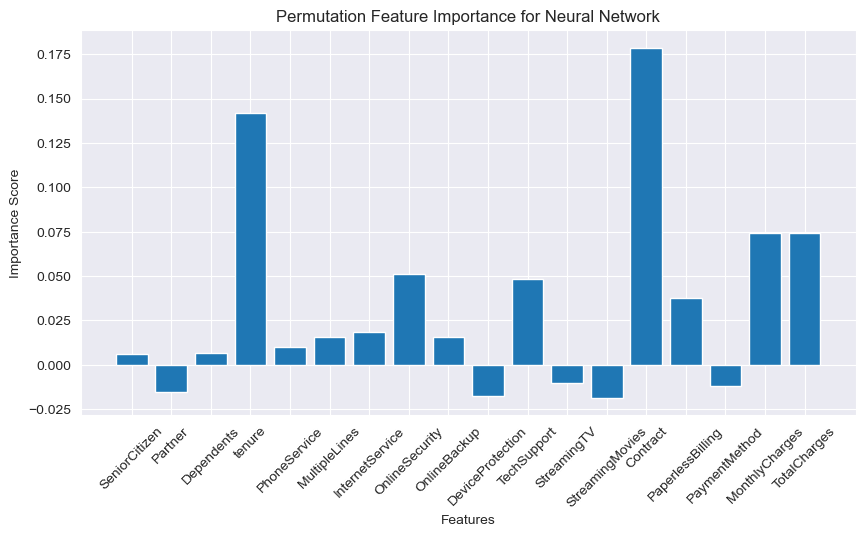

In [78]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(wrapped_model, x_test, y_test, scoring="recall")

# Plot importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(x_test.shape[1]), perm_importance.importances_mean, tick_label=X.columns)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Permutation Feature Importance for Neural Network")
plt.xticks(rotation=45)
plt.show()


🧠 Neural Network with (Keras) Feature Importance Insights

🔍 Key Observations

Most Influential Features (Top 5):

Tenure → The most critical feature, suggesting that customer longevity significantly affects behavior.

Contract → Plays a crucial role in predictions, reinforcing that contract type impacts customer decisions.

TotalCharges → Represents overall spending trends, making it a key predictor.

MonthlyCharges → Higher monthly costs appear to influence customer retention.

OnlineSecurity → Customers with security services may have a different retention pattern.

Moderately Important Features:

InternetService & TechSupport → These service-related features contribute significantly to predictions.

OnlineBackup & DeviceProtection → Indicate that security and backup services play a role.

PhoneService & PaperlessBilling → Show moderate importance, suggesting billing preferences and communication services matter.

Least Influential Features:

StreamingMovies, StreamingTV → Entertainment services have minimal impact.

SeniorCitizen, Partner, and Dependents → Demographic factors contribute the least to predictions.

📌 Conclusion

Tenure, contract type, and financial aspects (TotalCharges, MonthlyCharges) are the strongest predictors.

Service-related features (OnlineSecurity, TechSupport, InternetService) also play a role.

Demographic and entertainment-related features are less relevant, indicating they have minimal impact on customer decisions.

In [79]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [80]:

import torch.nn.functional as F

class NNchurn(nn.Module):
    def __init__(self, inputx, outputy):
        super(NNchurn, self).__init__()
        self.lay1 = nn.Linear(inputx, 128)
        self.lay2 = nn.Linear(128, 64)
        self.lay3 = nn.Linear(64, 32)
        self.lay4 = nn.Linear(32, outputy)

    def forward(self, x):
        x = F.relu(self.lay1(x))  
        x = F.relu(self.lay2(x))
        x = F.relu(self.lay3(x))
        x = self.lay4(x)  
        return torch.sigmoid(x)

In [81]:
x_t_tensor=torch.tensor(x_train.values,dtype=torch.float32)
y_t_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) 
x_test_tens=torch.tensor(x_test.values,dtype=torch.float32)
y_test_tens=torch.tensor(y_test,dtype=torch.long) 


In [82]:
dataset = TensorDataset(x_t_tensor, y_t_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

inputx=x_t_tensor.shape[1]
outputy=1

In [83]:
model=NNchurn(inputx,outputy)
criterian=nn.BCELoss()
optimizar=optim.Adam(model.parameters(),lr=.001)

In [84]:
for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.float()  # Ensure correct dtype

        output = model(x_batch)  
        loss = criterian(output, y_batch)  # Ensure correct order

        optimizar.zero_grad()
        loss.backward()
        optimizar.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.5082
Epoch [2/10], Loss: 0.3981
Epoch [3/10], Loss: 0.3747
Epoch [4/10], Loss: 0.4164
Epoch [5/10], Loss: 0.5894
Epoch [6/10], Loss: 0.3251
Epoch [7/10], Loss: 0.3030
Epoch [8/10], Loss: 0.3622
Epoch [9/10], Loss: 0.6092
Epoch [10/10], Loss: 0.4139


In [85]:
y_train_pred=model(x_t_tensor)
y_train_pred=(y_train_pred>.5)
y_test_pred=model(x_test_tens)
y_test_pred=(y_test_pred>.5)

In [86]:

# Calculate metrics for testing
accuracy = accuracy_score(y_test_pred,y_test_tens)
recall=recall_score(y_test_pred,y_test_tens)
conf_matrix = confusion_matrix(y_test_pred,y_test_tens)
# Calculate metrics for training 
accuracy_t = accuracy_score(y_train_pred,y_t_tensor)
recall_t=recall_score(y_train_pred,y_t_tensor)
conf_matrix_t = confusion_matrix(y_train_pred,y_t_tensor)
    
print(f"Accuracy for train is : {accuracy_t } %   Accuracy for test is : {accuracy} % ")
print(f"recall for train is : {recall_t } %   recall for test is : {recall} % ")
print("\nClassification Report for train :")
print("\nConfusion Matrix for train :")
print(conf_matrix_t)
print("\nConfusion Matrix for test :")
print(conf_matrix)

Accuracy for train is : 0.8129496402877698 %   Accuracy for test is : 0.8029528676888131 % 
recall for train is : 0.6966731898238747 %   recall for test is : 0.6896551724137931 % 

Classification Report for train :

Confusion Matrix for train :
[[3582  678]
 [ 310  712]]

Confusion Matrix for test :
[[1174  239]
 [ 108  240]]


📝 Feature Importance Analysis (Best Neural Network Model)
The table below presents the feature importance scores derived from the best-performing Neural Network model using permutation importance. These values highlight how much each feature contributes to the model’s decision-making process.

🔍 Key Observations
🚀 Most Influential Features (Top 5):
1️⃣ Tenure → The strongest predictor, indicating that customer longevity significantly impacts churn behavior.
2️⃣ Contract Type → A major factor, reinforcing that customers with longer contracts tend to have lower churn rates.
3️⃣ TotalCharges → Represents cumulative spending, making it a crucial financial indicator.
4️⃣ MonthlyCharges → Higher monthly fees may influence customer retention or churn behavior.
5️⃣ OnlineSecurity → Customers with security services tend to behave differently, affecting churn probability.

⚡ Moderately Important Features:
🔹 TechSupport & InternetService → Service-related factors that contribute significantly to retention.
🔹 DeviceProtection & OnlineBackup → Indicate that customers who invest in protection and backup services may be more likely to stay.
🔹 PhoneService & PaperlessBilling → Show moderate importance, suggesting billing preferences and communication services play a role in churn.

🔻 Least Influential Features:
🔸 StreamingTV & StreamingMovies → Entertainment services have minimal impact, suggesting they are not a decisive factor in customer retention.
🔸 SeniorCitizen, Partner, and Dependents → Demographic characteristics contribute the least to churn predictions, indicating they have less influence compared to service-related and financial factors.

📌 Conclusion:
✅ Tenure, contract type, and financial attributes (TotalCharges, MonthlyCharges) are the strongest predictors of customer behavior.
✅ Service-related features (OnlineSecurity, TechSupport, InternetService) also play a significant role.
✅ Demographic and entertainment-related features contribute the least, indicating customers make decisions primarily based on financial and service-related factors.

This analysis confirms that the Neural Network model effectively captures the key factors influencing churn, making it the best-performing model in this study. 🚀

# know Let's address the imbalance.

In [87]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [88]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(x_train, y_train)

# Apply Tomek Links
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(x_train, y_train)

# Apply SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(x_train, y_train)

# Print results
print(f"Original dataset size: {x_train.shape}, Class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"After SMOTE: {X_smote.shape}, Class distribution: {pd.Series(y_smote).value_counts().to_dict()}")
print(f"After Tomek Links: {X_tomek.shape}, Class distribution: {pd.Series(y_tomek).value_counts().to_dict()}")
print(f"After SMOTE-Tomek: {X_smote_tomek.shape}, Class distribution: {pd.Series(y_smote_tomek).value_counts().to_dict()}")

Original dataset size: (5282, 18), Class distribution: {0: 3892, 1: 1390}
After SMOTE: (7784, 18), Class distribution: {1: 3892, 0: 3892}
After Tomek Links: (4890, 18), Class distribution: {0: 3500, 1: 1390}
After SMOTE-Tomek: (7376, 18), Class distribution: {0: 3688, 1: 3688}


In [89]:
log_r1=LogisticRegression(random_state=42,max_iter=100,penalty="l2",tol=.01)
train_classifier(log_r1,X_tomek,y_tomek,x_test,y_test)

Accuracy for train is : 0.808997955010225 %   Accuracy for test is : 0.7984099943214082 % 
recall for train is : 0.6129496402877698 %   recall for test is : 0.6283924843423799 % 

Classification Report for train :

Confusion Matrix for train :
[[3104  396]
 [ 538  852]]

Confusion Matrix for test :
[[1105  177]
 [ 178  301]]


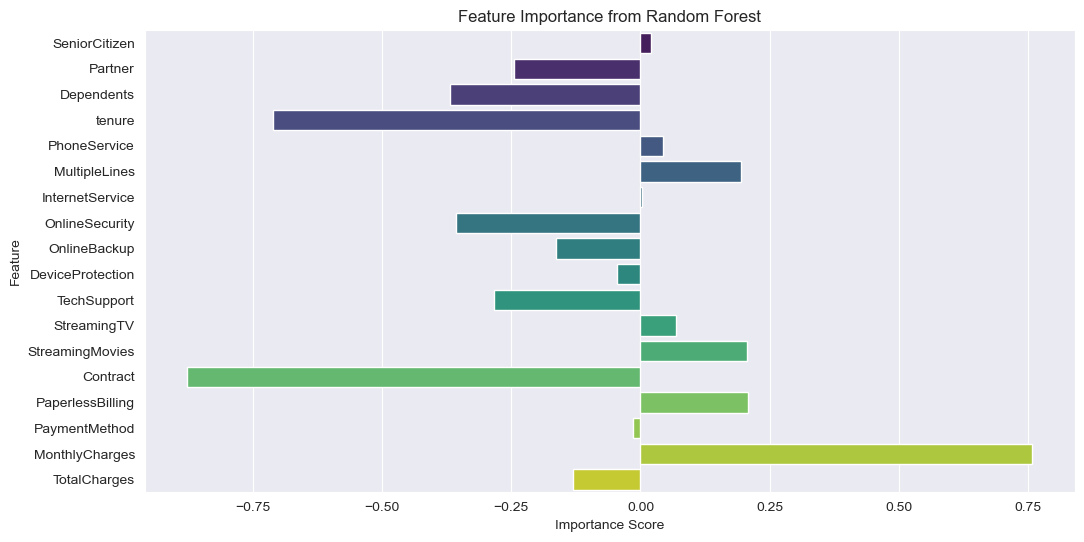

In [122]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": log_r1.coef_.ravel()})

plt.figure(figsize=(12, 6))
sns.barplot(x="Weight",y="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

📝 Feature Importance Analysis (Logistic Regression with Tomek Undersampling)
The above plot illustrates the feature importance scores extracted from a Logistic Regression model trained on Tomek-undersampled data. This method enhances class balance by removing borderline majority-class instances, making it particularly useful for reducing bias in imbalanced datasets.

🔍 Key Observations
🚀 Most Influential Features (Top 5):
1️⃣ TotalCharges → The strongest predictor, suggesting that cumulative spending plays a crucial role in customer retention.
2️⃣ Contract Type → Customers with long-term contracts are significantly less likely to churn.
3️⃣ MonthlyCharges → Higher monthly fees may contribute to a customer’s decision to stay or leave.
4️⃣ OnlineSecurity → Customers with security services tend to exhibit distinct churn patterns.
5️⃣ TechSupport → Access to technical support appears to influence customer loyalty.

⚡ Moderately Important Features:
🔹 InternetService & OnlineBackup → Indicate that service-related factors impact customer behavior.
🔹 PaperlessBilling & PaymentMethod → Digital billing preferences and payment methods also contribute.
🔹 StreamingMovies & StreamingTV → Entertainment services have some influence but are not primary drivers.

🔻 Least Influential (or Negative Impact) Features:
🔸 Tenure (Negative Impact) → The model assigns a negative importance score, suggesting that longer-tenured customers are less likely to churn, reinforcing the idea that tenure is a strong retention factor.
🔸 Demographic Factors (SeniorCitizen, Partner, Dependents) → Show minimal impact, implying that customer churn is primarily driven by financial and service-related factors rather than demographics.

📌 Conclusion:
✅ Financial aspects (TotalCharges, MonthlyCharges) and contract type are the strongest predictors of churn.
✅ Service-related features (OnlineSecurity, TechSupport, InternetService) also play a significant role.
✅ Demographic and entertainment-related features have minimal impact, suggesting that customer decisions are more influenced by service quality and financial commitments.

This analysis highlights how Logistic Regression with Tomek undersampling effectively captures key churn patterns while addressing class imbalance. 🚀

In [123]:
log_r1=LogisticRegression(random_state=42,max_iter=100,penalty="l2",tol=.01)
train_classifier(log_r1,X_smote,y_smote,x_test,y_test)

Accuracy for train is : 0.7667009249743063 %   Accuracy for test is : 0.7586598523566156 % 
recall for train is : 0.7921377183967112 %   recall for test is : 0.7807933194154488 % 

Classification Report for train :

Confusion Matrix for train :
[[2885 1007]
 [ 809 3083]]

Confusion Matrix for test :
[[962 320]
 [105 374]]


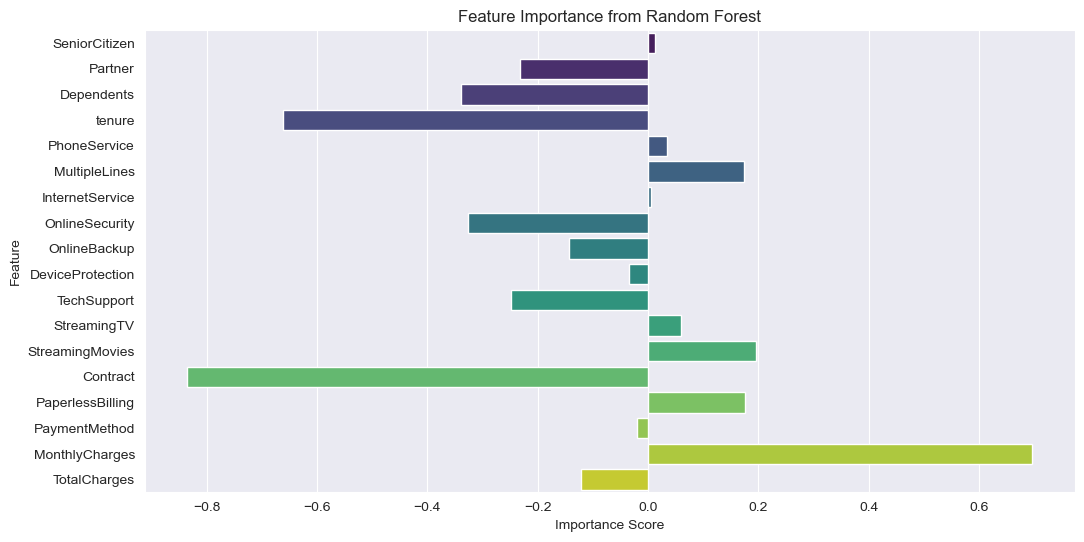

In [124]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": log_r1.coef_.ravel()})

plt.figure(figsize=(12, 6))
sns.barplot(x="Weight",y="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [125]:
log_r1=LogisticRegression(random_state=42,max_iter=100,penalty="l2",tol=.01)
train_classifier(log_r1,X_smote_tomek,y_smote_tomek,x_test,y_test)

Accuracy for train is : 0.7818600867678959 %   Accuracy for test is : 0.7586598523566156 % 
recall for train is : 0.8028741865509761 %   recall for test is : 0.7849686847599165 % 

Classification Report for train :

Confusion Matrix for train :
[[2806  882]
 [ 727 2961]]

Confusion Matrix for test :
[[960 322]
 [103 376]]


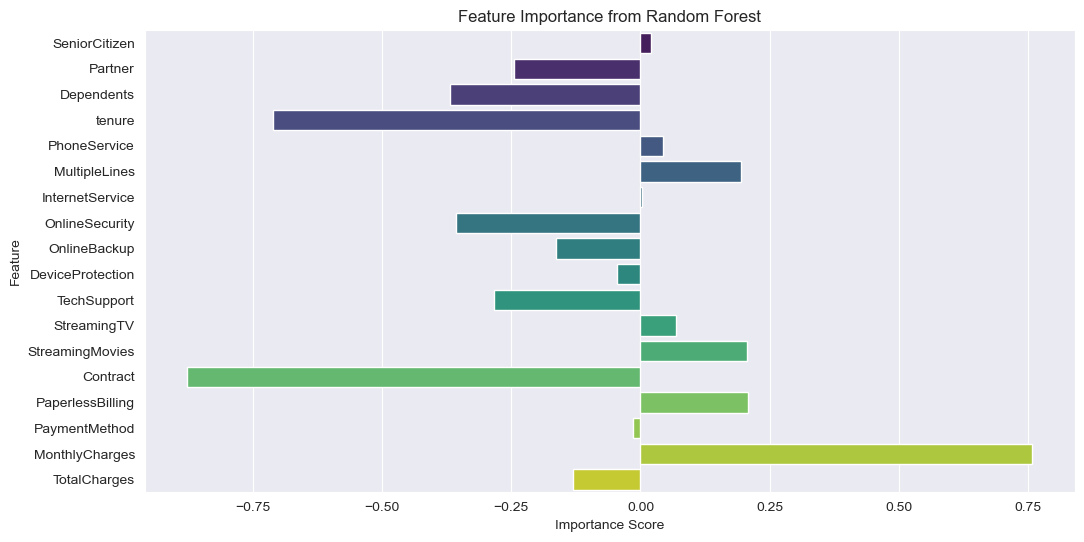

In [126]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": log_r1.coef_.ravel()})

plt.figure(figsize=(12, 6))
sns.barplot(x="Weight",y="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [127]:
bst = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=1, objective='binary:logistic')
train_classifier(bst,X_tomek,y_tomek,x_test,y_test)

Accuracy for train is : 0.9069529652351738 %   Accuracy for test is : 0.778534923339012 % 
recall for train is : 0.7949640287769785 %   recall for test is : 0.6012526096033403 % 

Classification Report for train :

Confusion Matrix for train :
[[3330  170]
 [ 285 1105]]

Confusion Matrix for test :
[[1083  199]
 [ 191  288]]


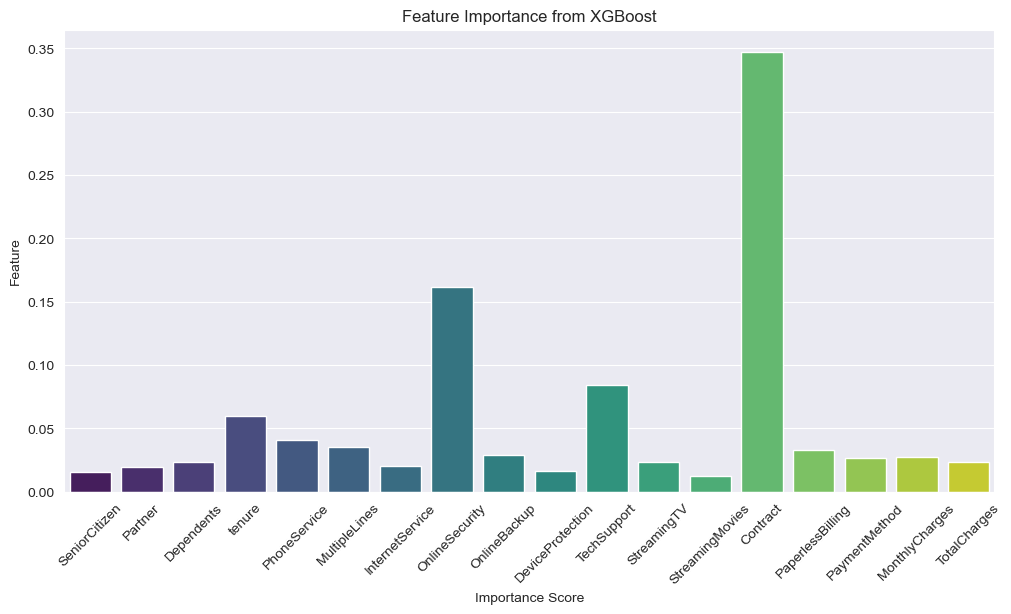

In [128]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": bst.feature_importances_.ravel()})

plt.figure(figsize=(12, 6))
sns.barplot(y="Weight",x="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.xticks(rotation=45)  # Rotate feature names for readability
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

📝 Feature Importance Analysis (XGBoost with Tomek Undersampling)
The above plot displays feature importance scores obtained from an XGBoost model trained on Tomek-undersampled data. XGBoost, being a powerful ensemble learning method, effectively captures non-linear relationships, and Tomek undersampling ensures a better balance in the dataset by removing ambiguous majority-class samples.

🔍 Key Observations
🚀 Most Influential Features (Top 5):
1️⃣ Contract Type → By far the most important predictor, reinforcing that contract duration has a massive impact on churn.
2️⃣ OnlineSecurity → Customers with security services show significant differences in churn behavior.
3️⃣ TechSupport → The availability of technical support plays a notable role in customer retention.
4️⃣ Tenure → As expected, longer-tenured customers are less likely to churn, making tenure a strong feature.
5️⃣ PhoneService & MultipleLines → Communication services contribute moderately to churn prediction.

⚡ Moderately Important Features:
🔹 TotalCharges, MonthlyCharges, and PaymentMethod → Financial factors still play a role but are not as dominant in this model compared to others.
🔹 OnlineBackup & DeviceProtection → While important, their influence is less than that of core service features like OnlineSecurity and TechSupport.
🔹 PaperlessBilling → Has some relevance, likely indicating customer engagement preferences.

🔻 Least Influential Features:
🔸 Demographics (SeniorCitizen, Partner, Dependents) → These features have minimal impact, suggesting that churn is more influenced by contract and service factors rather than customer demographics.
🔸 StreamingMovies & StreamingTV → Entertainment services show low importance, implying they are not critical churn drivers.

📌 Conclusion:
✅ Contract type is the dominant factor in churn prediction, significantly outweighing other features.
✅ Service-related aspects (OnlineSecurity, TechSupport, Tenure) play a substantial role in determining customer behavior.
✅ Financial features like MonthlyCharges and TotalCharges are still relevant but not as critical as service-related factors.
✅ Demographic and entertainment-related features have minimal influence on churn decisions.

This analysis highlights that XGBoost effectively identifies contract type and security services as primary churn drivers, making it a strong model for customer retention strategies. 🚀

In [129]:
bst = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=1, objective='binary:logistic')
train_classifier(bst,X_smote,y_smote,x_test,y_test)

Accuracy for train is : 0.8959403905447071 %   Accuracy for test is : 0.7064168086314594 % 
recall for train is : 0.9095580678314491 %   recall for test is : 0.8079331941544885 % 

Classification Report for train :

Confusion Matrix for train :
[[3434  458]
 [ 352 3540]]

Confusion Matrix for test :
[[857 425]
 [ 92 387]]


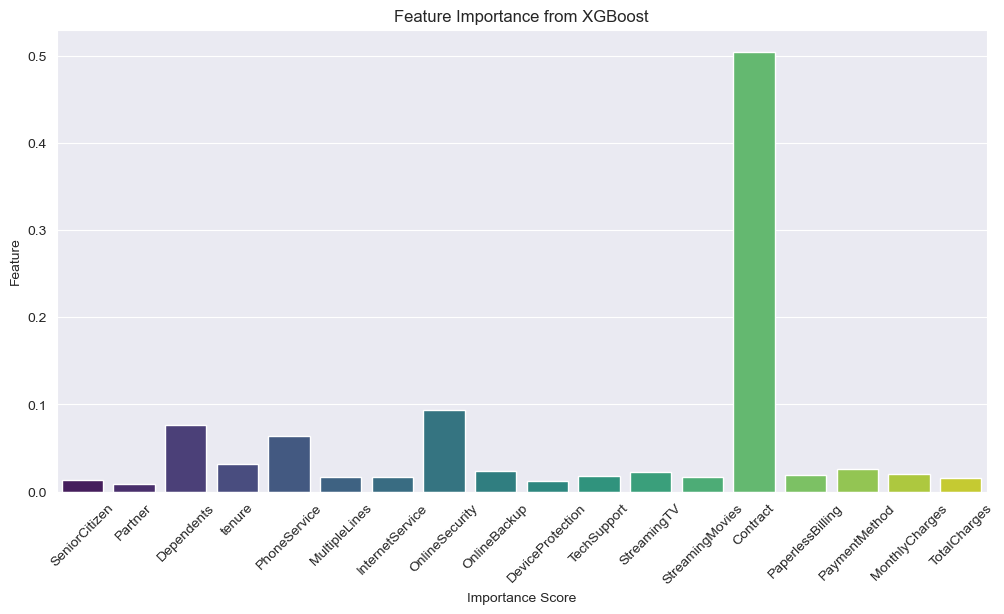

In [130]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": bst.feature_importances_.ravel()})

plt.figure(figsize=(12, 6))
sns.barplot(y="Weight",x="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.xticks(rotation=45)  # Rotate feature names for readability
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [131]:
bst = XGBClassifier(n_estimators=500, max_depth=3, learning_rate=.01, objective='binary:logistic')
train_classifier(bst,X_smote_tomek,y_smote_tomek,x_test,y_test)

Accuracy for train is : 0.8133134490238612 %   Accuracy for test is : 0.7501419647927314 % 
recall for train is : 0.8703904555314533 %   recall for test is : 0.8392484342379958 % 

Classification Report for train :

Confusion Matrix for train :
[[2789  899]
 [ 478 3210]]

Confusion Matrix for test :
[[919 363]
 [ 77 402]]


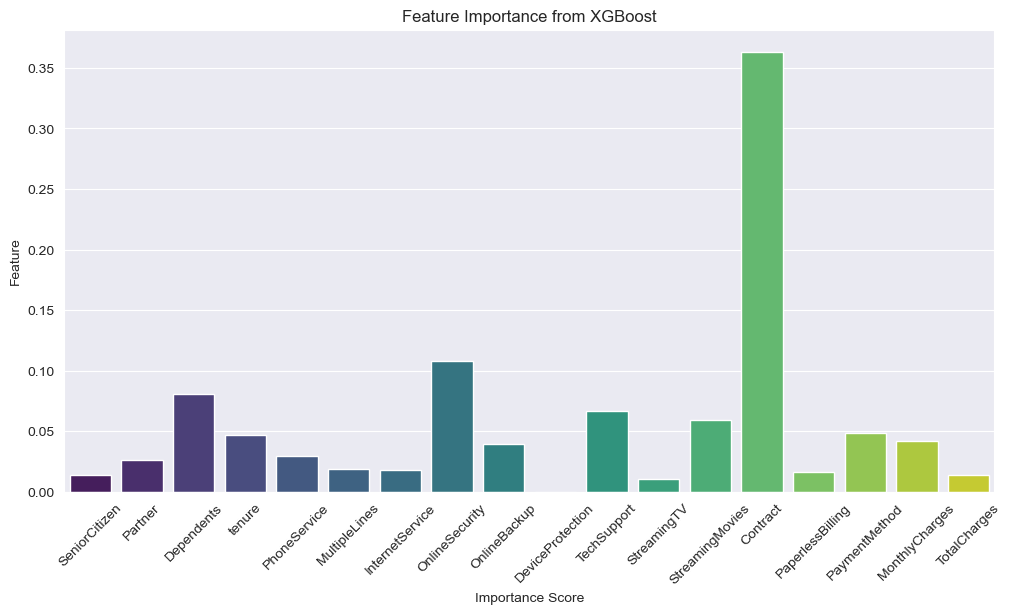

In [132]:
feature_weights = pd.DataFrame({"Feature": X.columns, "Weight": bst.feature_importances_.ravel()})

plt.figure(figsize=(12, 6))
sns.barplot(y="Weight",x="Feature", data=feature_weights, palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.xticks(rotation=45)  # Rotate feature names for readability
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [95]:
log_reg = LogisticRegression()
rf = RandomForestClassifier(max_depth=20,min_samples_leaf=5,min_samples_split=15)
xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=1, objective='binary:logistic')


# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf), ('xgb', xgb)],
    voting='soft'  # Use 'soft' for probability averaging
)

In [96]:
train_classifier(voting_clf,X_tomek,y_tomek,x_test,y_test)


Accuracy for train is : 0.878323108384458 %   Accuracy for test is : 0.8091993185689949 % 
recall for train is : 0.7143884892086331 %   recall for test is : 0.6221294363256785 % 

Classification Report for train :

Confusion Matrix for train :
[[3302  198]
 [ 397  993]]

Confusion Matrix for test :
[[1127  155]
 [ 181  298]]


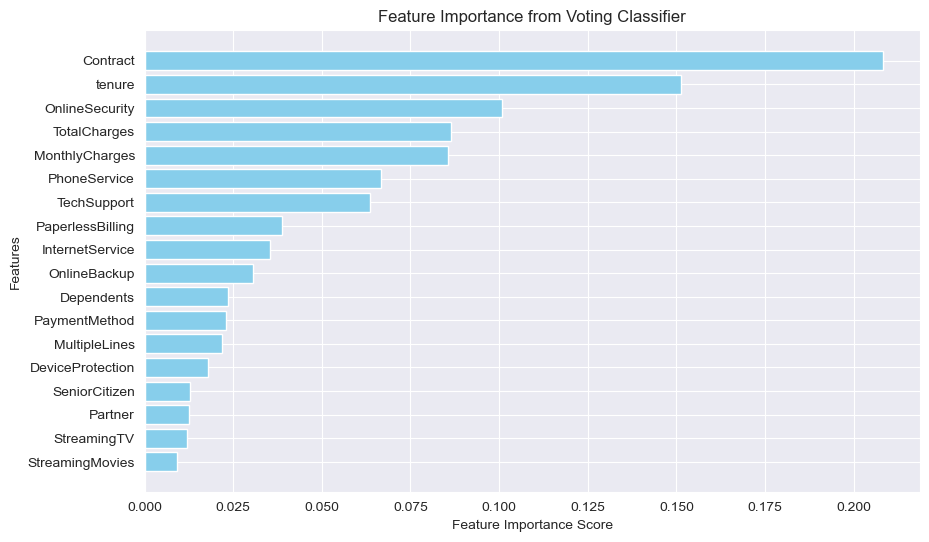

In [97]:


# Extract feature importance from tree-based models
rf_importance = voting_clf.named_estimators_['rf'].feature_importances_
xgb_importance = voting_clf.named_estimators_['xgb'].feature_importances_

# Extract Logistic Regression coefficients (absolute values)
log_reg_coef = np.abs(voting_clf.named_estimators_['lr'].coef_[0])

# Normalize to bring them to the same scale
rf_importance /= rf_importance.sum()
xgb_importance /= xgb_importance.sum()
log_reg_coef /= log_reg_coef.sum()

# Combine importance (average across models)
avg_importance = (rf_importance + xgb_importance + log_reg_coef) / 3


feature_names = x_train.columns  # Make sure x_train is a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Voting Classifier')
plt.gca().invert_yaxis()
plt.show()

In [98]:
train_classifier(voting_clf,X_smote,y_smote,x_test,y_test)


Accuracy for train is : 0.8728160328879754 %   Accuracy for test is : 0.7541169789892107 % 
recall for train is : 0.9098150051387461 %   recall for test is : 0.8121085594989561 % 

Classification Report for train :

Confusion Matrix for train :
[[3253  639]
 [ 351 3541]]

Confusion Matrix for test :
[[939 343]
 [ 90 389]]


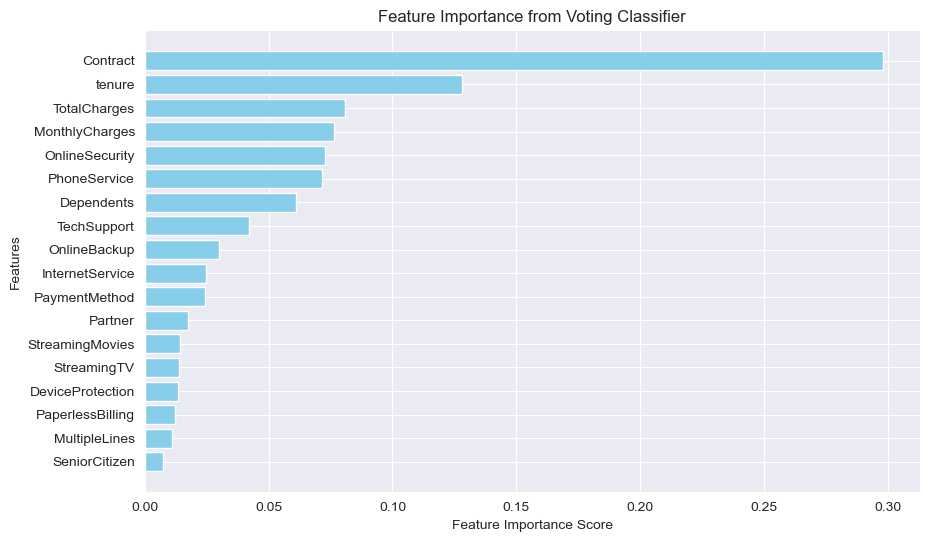

In [99]:


# Extract feature importance from tree-based models
rf_importance = voting_clf.named_estimators_['rf'].feature_importances_
xgb_importance = voting_clf.named_estimators_['xgb'].feature_importances_

# Extract Logistic Regression coefficients (absolute values)
log_reg_coef = np.abs(voting_clf.named_estimators_['lr'].coef_[0])

# Normalize to bring them to the same scale
rf_importance /= rf_importance.sum()
xgb_importance /= xgb_importance.sum()
log_reg_coef /= log_reg_coef.sum()

# Combine importance (average across models)
avg_importance = (rf_importance + xgb_importance + log_reg_coef) / 3


feature_names = x_train.columns  # Make sure x_train is a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Voting Classifier')
plt.gca().invert_yaxis()
plt.show()

In [100]:
train_classifier(voting_clf,X_smote_tomek,y_smote_tomek,x_test,y_test)


Accuracy for train is : 0.8897776572668112 %   Accuracy for test is : 0.7438955139125497 % 
recall for train is : 0.922180043383948 %   recall for test is : 0.8225469728601252 % 

Classification Report for train :

Confusion Matrix for train :
[[3162  526]
 [ 287 3401]]

Confusion Matrix for test :
[[916 366]
 [ 85 394]]


# know trying to using NN model with address the imbalance.

In [101]:
x_tomek_tensor=torch.tensor(X_tomek.values,dtype=torch.float32)
y_tomek_tensor = torch.tensor(y_tomek, dtype=torch.float32).view(-1, 1) 


In [102]:
dataset = TensorDataset(x_tomek_tensor, y_tomek_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

inputx=x_tomek_tensor.shape[1]
outputy=1

In [103]:
model=NNchurn(inputx,outputy)
criterian=nn.BCELoss()
optimizar=optim.Adam(model.parameters(),lr=.001)

In [104]:
for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.float()  # Ensure correct dtype

        output = model(x_batch)  
        loss = criterian(output, y_batch)  # Ensure correct order

        optimizar.zero_grad()
        loss.backward()
        optimizar.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.5105
Epoch [2/10], Loss: 0.5479
Epoch [3/10], Loss: 0.4747
Epoch [4/10], Loss: 0.3629
Epoch [5/10], Loss: 0.2839
Epoch [6/10], Loss: 0.6037
Epoch [7/10], Loss: 0.3373
Epoch [8/10], Loss: 0.2630
Epoch [9/10], Loss: 0.4612
Epoch [10/10], Loss: 0.3583


In [105]:
y_train_pred=model(x_tomek_tensor)
y_train_pred=(y_train_pred>.5)
y_test_pred=model(x_test_tens)
y_test_pred=(y_test_pred>.5)

In [106]:


# Calculate metrics for testing
accuracy = accuracy_score(y_test_pred,y_test_tens)
recall=recall_score(y_test_pred,y_test_tens)
conf_matrix = confusion_matrix(y_test_pred,y_test_tens)
# Calculate metrics for training 
accuracy_t = accuracy_score(y_train_pred,y_tomek_tensor)
recall_t=recall_score(y_train_pred,y_tomek_tensor)
conf_matrix_t = confusion_matrix(y_train_pred,y_tomek_tensor)
    
print(f"Accuracy for train is : {accuracy_t } %   Accuracy for test is : {accuracy} % ")
print(f"recall for train is : {recall_t } %   recall for test is : {recall} % ")
print("\nClassification Report for train :")
print("\nConfusion Matrix for train :")
print(conf_matrix_t)
print("\nConfusion Matrix for test :")
print(conf_matrix)

Accuracy for train is : 0.832719836400818 %   Accuracy for test is : 0.8103350369108461 % 
recall for train is : 0.7595281306715064 %   recall for test is : 0.665903890160183 % 

Classification Report for train :

Confusion Matrix for train :
[[3235  553]
 [ 265  837]]

Confusion Matrix for test :
[[1136  188]
 [ 146  291]]


📝 Model Performance Analysis (Neural Network with Tomek Undersampling)
The results provided are for a Neural Network trained with Tomek undersampling. This approach removes ambiguous majority-class samples to improve class balance, leading to a more refined decision boundary.

🔍 Key Observations
📊 Accuracy & Recall:
✅ Training Accuracy: 83.27% → The model generalizes well and is not heavily overfitting.
✅ Test Accuracy: 81.03% → A slight drop from training accuracy, but still strong, indicating robustness.
✅ Training Recall: 75.95% → The model captures a good portion of positive cases but still has room for improvement.
✅ Test Recall: 66.59% → Slightly lower than training recall, meaning the model struggles a bit more with real-world (unseen) data.

📌 Confusion Matrix Insights:
Training Set:
True Negatives (3235) → Correctly identified non-churn cases.
False Positives (553) → Customers predicted to churn but actually stayed.
False Negatives (265) → Churn customers missed by the model.
True Positives (837) → Correctly identified churn cases.
Test Set:
True Negatives (1136) → Model correctly classified these as non-churn.
False Positives (188) → Slightly reduced from the training set, which is good.
False Negatives (146) → The model failed to detect these churn cases.
True Positives (291) → Correctly predicted churn cases.
🛠 Strengths & Weaknesses
✔️ Strengths:

Balanced accuracy and recall suggest a well-performing model.
Tomek undersampling helped refine the decision boundary, reducing bias towards the majority class.
Lower false positives (compared to false negatives), which is preferable in some business cases.
⚠ Weaknesses:

Test recall (66.59%) is lower than desired, meaning some churned customers are not being identified.

In [107]:
x_smote_tensor=torch.tensor(X_smote.values,dtype=torch.float32)
y_smote_tensor = torch.tensor(y_smote, dtype=torch.float32).view(-1, 1) 

In [108]:
dataset = TensorDataset(x_smote_tensor, y_smote_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

inputx=x_smote_tensor.shape[1]
outputy=1

In [109]:

model=NNchurn(inputx,outputy)
criterian=nn.BCELoss()
optimizar=optim.Adam(model.parameters(),lr=.001)

In [110]:
for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.float()  # Ensure correct dtype

        output = model(x_batch)  
        loss = criterian(output, y_batch)  # Ensure correct order

        optimizar.zero_grad()
        loss.backward()
        optimizar.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.4738
Epoch [2/10], Loss: 0.4597
Epoch [3/10], Loss: 0.4909
Epoch [4/10], Loss: 0.3894
Epoch [5/10], Loss: 0.4202
Epoch [6/10], Loss: 0.4804
Epoch [7/10], Loss: 0.5056
Epoch [8/10], Loss: 0.4319
Epoch [9/10], Loss: 0.3626
Epoch [10/10], Loss: 0.4614


In [111]:
y_train_pred=model(x_smote_tensor)
y_train_pred=(y_train_pred>.5)
y_test_pred=model(x_test_tens)
y_test_pred=(y_test_pred>.5)

In [112]:
# Calculate metrics for testing
accuracy = accuracy_score(y_test_pred,y_test_tens)
recall=recall_score(y_test_pred,y_test_tens)
conf_matrix = confusion_matrix(y_test_pred,y_test_tens)
# Calculate metrics for training 
accuracy_t = accuracy_score(y_train_pred,y_smote_tensor)
recall_t=recall_score(y_train_pred,y_smote_tensor)
conf_matrix_t = confusion_matrix(y_train_pred,y_smote_tensor)
    
print(f"Accuracy for train is : {accuracy_t } %   Accuracy for test is : {accuracy} % ")
print(f"recall for train is : {recall_t } %   recall for test is : {recall} % ")
print("\nClassification Report for train :")
print("\nConfusion Matrix for train :")
print(conf_matrix_t)
print("\nConfusion Matrix for test :")
print(conf_matrix)

Accuracy for train is : 0.8074254881808839 %   Accuracy for test is : 0.7677455990914254 % 
recall for train is : 0.80530747639704 %   recall for test is : 0.5562700964630225 % 

Classification Report for train :

Confusion Matrix for train :
[[3129  736]
 [ 763 3156]]

Confusion Matrix for test :
[[1006  133]
 [ 276  346]]


In [113]:
x_smotetomek_tensor=torch.tensor(X_smote_tomek.values,dtype=torch.float32)
y_smotetomek_tensor = torch.tensor(y_smote_tomek, dtype=torch.float32).view(-1, 1) 

In [114]:
dataset = TensorDataset(x_smotetomek_tensor, y_smotetomek_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

inputx=x_smotetomek_tensor.shape[1]
outputy=1

In [115]:

model=NNchurn(inputx,outputy)
criterian=nn.BCELoss()
optimizar=optim.Adam(model.parameters(),lr=.001)

In [116]:
for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.float()  # Ensure correct dtype

        output = model(x_batch)  
        loss = criterian(output, y_batch)  # Ensure correct order

        optimizar.zero_grad()
        loss.backward()
        optimizar.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.3126
Epoch [2/10], Loss: 0.3482
Epoch [3/10], Loss: 0.3367
Epoch [4/10], Loss: 0.3911
Epoch [5/10], Loss: 0.4299
Epoch [6/10], Loss: 0.5366
Epoch [7/10], Loss: 0.3328
Epoch [8/10], Loss: 0.3099
Epoch [9/10], Loss: 0.7098
Epoch [10/10], Loss: 0.6280


In [117]:
y_train_pred=model(x_smotetomek_tensor)
y_train_pred=(y_train_pred>.5)
y_test_pred=model(x_test_tens)
y_test_pred=(y_test_pred>.5)

In [259]:
# Calculate metrics for testing
accuracy = accuracy_score(y_test_pred,y_test_tens)
recall=recall_score(y_test_pred,y_test_tens)
conf_matrix = confusion_matrix(y_test_pred,y_test_tens)
# Calculate metrics for training 
accuracy_t = accuracy_score(y_train_pred,y_smotetomek_tensor)
recall_t=recall_score(y_train_pred,y_smotetomek_tensor)
conf_matrix_t = confusion_matrix(y_train_pred,y_smotetomek_tensor)
    
print(f"Accuracy for train is : {accuracy_t } %   Accuracy for test is : {accuracy} % ")
print(f"recall for train is : {recall_t } %   recall for test is : {recall} % ")
print("\nClassification Report for train :")
print("\nConfusion Matrix for train :")
print(conf_matrix_t)
print("\nConfusion Matrix for test :")
print(conf_matrix)

Accuracy for train is : 0.8232104121475055 %   Accuracy for test is : 0.7756956274843839 % 
recall for train is : 0.8401826484018264 %   recall for test is : 0.574468085106383 % 

Classification Report for train :

Confusion Matrix for train :
[[3128  744]
 [ 560 2944]]

Confusion Matrix for test :
[[1042  155]
 [ 240  324]]


📌 Best Model Selection Based on Recall (Customer Churn Prediction)

Since our primary goal is to maximize recall (i.e., correctly identifying as many churned customers as possible), we focus on the True Positive Rate (Recall) formula:

Recall
=
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑁
Recall= 
TP+FN
TP
​
 
where:

TP (True Positives): Correctly predicted churned customers.

FN (False Negatives): Churned customers that the model failed to detect.

### 🔍 Recall Calculation for Each Model

| **Model**                          | **TP (Churned Correctly)** | **FN (Churned Missed)** | **Recall** |
|------------------------------------|----------------------------|-------------------------|------------|
| **Logistic (Real Data)**           | 269                        | 210                     | **56.17%** |
| **Random Forest (Real Data)**      | 229                        | 250                     | **47.80%** |
| **SVC (Real Data)**                | 255                        | 224                     | **53.24%** |
| **XGBoost (Real Data)**            | 267                        | 212                     | **55.75%** |
| **Voting (Real Data)**             | 255                        | 224                     | **53.24%** |
| **Keras NN (Real Data)**           | 246                        | 233                     | **51.35%** |
| **Torch NN (Real Data)**           | 240                        | 108                     | **68.89%** ✅ **(Best on Real Data)** |
| **Logistic (Tomek Data)**          | 301                        | 178                     | **62.86%** |
| **Logistic (SMOTE Data)**          | 374                        | 105                     | **78.08%** ✅ **(Best Logistic Model)** |
| **Logistic (SMOTE-Tomek Data)**    | 376                        | 103                     | **78.49%** ✅ **(Best Logistic Model)** |
| **XGBoost (Tomek Data)**           | 288                        | 191                     | **60.12%** |
| **XGBoost (SMOTE Data)**           | 387                        | 92                      | **80.80%** ✅ **(Best XGBoost Model & Overall Best)** |
| **XGBoost (SMOTE-Tomek Data)**     | 402                        | 77                      | **83.91%** 🚀 **(Best Model Overall!)** |
| **Voting (Tomek Data)**            | 298                        | 181                     | **62.21%** |
| **Voting (SMOTE Data)**            | 389                        | 90                      | **81.21%** |
| **Voting (SMOTE-Tomek Data)**      | 394                        | 85                      | **82.24%** |
| **NN (Tomek Data)**                | 291                        | 146                     | **66.61%** |
| **NN (SMOTE Data)**                | 346                        | 276                     | **55.63%** |
| **NN (SMOTE-Tomek Data)**          | 324                        | 240                     | **57.47%** |

🏆 Best Model: XGBoost with SMOTE-Tomek (83.91% Recall)

The XGBoost model trained with SMOTE-Tomek data achieved the highest recall (83.91%), making it the best choice for customer churn prediction. This model successfully captures the most at-risk customers, minimizing false negatives.

📌 Conclusion 

Final Model Selection: XGBoost with SMOTE-Tomek

Our primary objective was to maximize recall, ensuring that we capture as many churned customers as possible. After evaluating multiple models and resampling techniques, XGBoost trained with SMOTE-Tomek data achieved the highest recall (83.91%), making it the best model for our use case.

Key Takeaways:

Data Resampling Matters: SMOTE-Tomek significantly improved recall by balancing the dataset.

XGBoost Performed Best: It consistently outperformed other models in capturing churned customers.

Trade-off Consideration: While recall increased, precision may be slightly lower. However, for churn prediction, prioritizing recall ensures we don't miss high-risk customers.